In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import pyedflib
import mne
import neurokit2 as nk2
import p_tqdm
from scipy.stats import trim_mean
from scipy import signal
from scipy.optimize import least_squares
import statsmodels.api as sm
from collections import defaultdict
import wfdb
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RANSACRegressor
from scipy.interpolate import interp1d
import shutil
from scipy.signal import savgol_filter

In [2]:
path=('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/*')
glob.glob('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/*')

['/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x010_NEXUS.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x001_SOT.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x011_SOT.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x004_NEXUS.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x002_POLAR.hrm',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x013_HX.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x003_FAROS.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x009_NEXUS.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x001_HX.edf',
 '/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x008_SOT.edf',
 '

In [3]:
dfs = defaultdict(lambda: defaultdict(pd.DataFrame))

for files in glob.glob('/Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/*'):
    key = os.path.splitext(os.path.basename(files))[1]
    base_name = os.path.splitext(os.path.basename(files))[0]
    sensor = base_name.split('_')[-1]
    if key == '.edf':
        file = mne.io.read_raw_edf(files)
        file = file.to_data_frame()
    else:
        file = pd.read_csv(files, on_bad_lines='skip', names=['R-R Interval (ms)'])
    dfs[sensor][base_name] = file

Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x010_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x001_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x011_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x004_NEXUS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x013_HX.edf...
EDF file detected
Se

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x007_FAROS.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x002_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x010_HX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiological Measurements at Different Loads/raw_data/x005_SOT.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /Users/jaredperez/Multiple Physiologic

In [9]:
test=dfs['FAROS']['x006_FAROS']
test

time      ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  32767.0     7.595000e+08     2.890000e+08    -5.590000e+08   
1           0.001  32767.0     7.590085e+08     2.854055e+08    -5.609943e+08   
2           0.002  32767.0     7.588405e+08     2.828519e+08    -5.622517e+08   
3           0.003  32767.0     7.589696e+08     2.813497e+08    -5.627896e+08   
4           0.004  32767.0     7.593539e+08     2.808525e+08    -5.626682e+08   
...           ...      ...              ...              ...              ...   
2110995  2110.995    -39.0     9.442576e+07     3.899495e+08    -7.694913e+08   
2110996  2110.996    -24.0     1.689411e+08     2.797927e+08    -7.993757e+08   
2110997  2110.997      1.0     2.430424e+08     1.720602e+08    -8.266948e+08   
2110998  2110.998     20.0     3.139002e+08     7.083434e+07    -8.507179e+08   
2110999  2110.999      1.0     3.788357e+08    -2.020210e+07    -8.709189e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10 -1.455192e-08     2.937351e+07  
1       -3.276700e+10  1.427839e+06     2.937351e+07  
2       -3.276700e+10  2.867822e+06     2.937351e+07  
3       -3.276700e+10  4.319797e+06     2.937351e+07  
4       -3.276700e+10  5.783611e+06     2.937351e+07  
...               ...           ...              ...  
2110995 -3.276700e+10  0.000000e+00     3.133786e+07  
2110996 -3.276700e+10  0.000000e+00     3.133786e+07  
2110997 -3.276700e+10  0.000000e+00     3.133786e+07  
2110998 -3.276700e+10  0.000000e+00     3.133786e+07  
2110999 -3.276700e+10  0.000000e+00     3.133786e+07  

[2111000 rows x 8 columns]

In [50]:
signals,info=nk2.ecg_process(test['ECG'], sampling_rate=1000)
heart_rate=signals['ECG_Rate'][::2000] #Every 2 seconds...skip_factor
heart_rate=heart_rate.reset_index(drop=True)

In [51]:
values=heart_rate.rolling(100).mean()

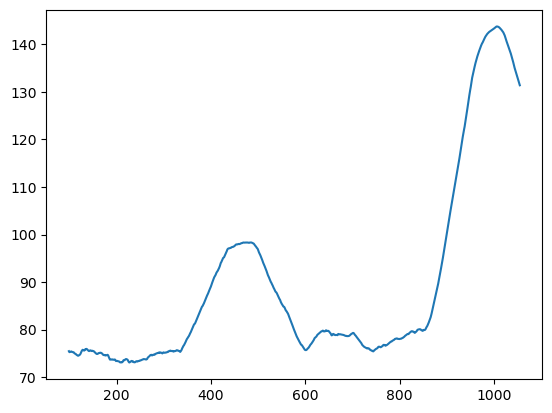

In [12]:
plt.plot(values)

In [332]:
def change_in_activity(heart_rate,rolling_average, bins, adjustment_factor=0):
    manual_cut = pd.cut(rolling_average, bins)
    beats = [rolling_average[manual_cut == category] for category in manual_cut.cat.categories]
    differences = [np.diff(beat.index) for beat in beats]
    ilocs = [[idx for idx, sequence in enumerate(state_difference) if sequence != 1] for state_difference in differences]

    fig,ax=plt.subplots(1,2)
    slices = []
    for i, index_set in enumerate(ilocs):
        prev_end = 0
        for j, end in enumerate(index_set):
            slice_start = prev_end
            slice_end = end
            if j == 0:
                slice_start = 0
            slice_1 = beats[i].iloc[slice_start+1:slice_end]
            slices.append(slice_1)
            ax[0].plot(slice_1)
            prev_end = end
        slice_start = prev_end
        slice_3 = beats[i].iloc[slice_start+1:]
        ax[0].plot(slice_3)
        slices.append(slice_3)

    slices=[i.reset_index() for i in slices]
    slices_indexes=[i['index'] for i in slices]
    new_indexes=[i.values[-1] for i in slices_indexes]
    new_indexes.sort()
    
    adjusted_indexes=[i+adjustment_factor for i in new_indexes]
    for i in range(len(adjusted_indexes)):
        if i == 0:
            ax[1].plot(heart_rate.iloc[:adjusted_indexes[i]])
        else:
            ax[1].plot(heart_rate.iloc[adjusted_indexes[i-1]:adjusted_indexes[i]])
            
    adjusted_indexes.pop(-1)
    
    return new_indexes, adjusted_indexes

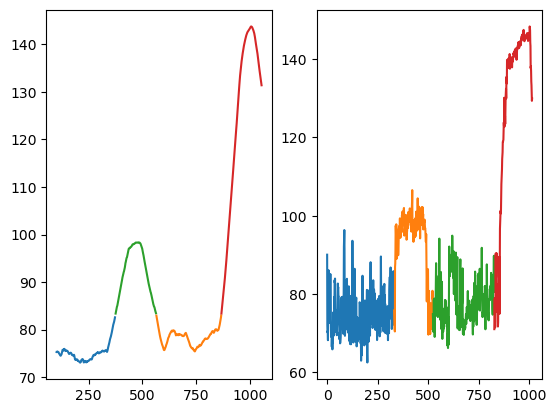

In [73]:
new_indexes, adjusted_indexes=change_in_activity(heart_rate, values, bins=[60,83,160], adjustment_factor=-40)

In [74]:
adjusted_indexes

[332, 523, 827]

In [57]:
test[::2000]

time      ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.0  32767.0      759500000.0      289000000.0    -5.590000e+08   
2000        2.0  20726.0      775000000.0      287000000.0    -5.510000e+08   
4000        4.0  14544.0      775000000.0      246000000.0    -5.825000e+08   
6000        6.0   9828.0      779000000.0      238000000.0    -5.530000e+08   
8000        8.0   6051.0      765500000.0      263500000.0    -5.645000e+08   
...         ...      ...              ...              ...              ...   
2102000  2102.0    317.0      -10000000.0       -6000000.0    -1.002000e+09   
2104000  2104.0    214.0       -6000000.0       -2000000.0    -1.020000e+09   
2106000  2106.0     87.0       -6000000.0       -4000000.0    -9.925000e+08   
2108000  2108.0     60.0      169500000.0       -6000000.0    -6.645000e+08   
2110000  2110.0     24.0      435500000.0      -98000000.0    -8.870000e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10 -1.455192e-08     2.937351e+07  
2000    -3.276700e+10  8.330000e+08     2.942520e+07  
4000    -3.276700e+10  1.455192e-08     2.947689e+07  
6000    -3.276700e+10  0.000000e+00     2.952859e+07  
8000    -3.276700e+10  0.000000e+00     2.942520e+07  
...               ...           ...              ...  
2102000 -3.276700e+10  0.000000e+00     3.149294e+07  
2104000 -3.276700e+10  0.000000e+00     3.144125e+07  
2106000 -3.276700e+10  0.000000e+00     3.144125e+07  
2108000 -3.276700e+10  0.000000e+00     3.144125e+07  
2110000 -3.276700e+10  0.000000e+00     3.133786e+07  

[1056 rows x 8 columns]

In [335]:
test

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
988    151.769222
989    151.388349
990    151.007656
991    150.654901
992    150.110015
Name: ECG_Rate, Length: 993, dtype: float64

In [77]:
tests=[test[::2000].iloc[i] for i in adjusted_indexes]

In [80]:
adjusted_indexes

[332, 523, 827]

In [119]:
def apply_new_indexes(original_df, adjusted_indexes, skip_factor):
    df=original_df[::skip_factor]
    df=df.reset_index()
    df = [df.iloc[i] for i in adjusted_indexes]
    OG_indexes = [int(i['index']) for i in df]
    new_dfs = []
    for i in range(len(adjusted_indexes)):
        if i == 0:
            new_df = original_df[:OG_indexes[i]]
        else:
            new_df = original_df[OG_indexes[i-1]:OG_indexes[i]]
        new_dfs.append(new_df)
    final_df=original_df[OG_indexes[i]:]
    new_dfs.append(final_df)
    
    return new_dfs

In [112]:
len(test_dfs)

4

In [111]:
test_dfs=apply_new_indexes(test, adjusted_indexes=adjusted_indexes, skip_factor=2000)

In [116]:
subject_6=test_dfs

In [290]:
subject_6[0]

time      ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0         0.000  32767.0     7.595000e+08     2.890000e+08    -5.590000e+08   
1         0.001  32767.0     7.590085e+08     2.854055e+08    -5.609943e+08   
2         0.002  32767.0     7.588405e+08     2.828519e+08    -5.622517e+08   
3         0.003  32767.0     7.589696e+08     2.813497e+08    -5.627896e+08   
4         0.004  32767.0     7.593539e+08     2.808525e+08    -5.626682e+08   
...         ...      ...              ...              ...              ...   
663995  663.995    879.0     7.454370e+08     4.815431e+08    -4.437831e+08   
663996  663.996    881.0     7.476947e+08     4.796316e+08    -4.469024e+08   
663997  663.997    871.0     7.499150e+08     4.777292e+08    -4.501186e+08   
663998  663.998    857.0     7.520119e+08     4.758788e+08    -4.532929e+08   
663999  663.999    859.0     7.538998e+08     4.741227e+08    -4.562928e+08   

              Marker           HRV  DEV_Temperature  
0      -3.276700e+10 -1.455192e-08     2.937351e+07  
1      -3.276700e+10  1.427839e+06     2.937351e+07  
2      -3.276700e+10  2.867822e+06     2.937351e+07  
3      -3.276700e+10  4.319797e+06     2.937351e+07  
4      -3.276700e+10  5.783611e+06     2.937351e+07  
...              ...           ...              ...  
663995 -3.276700e+10  1.316691e+07     3.014891e+07  
663996 -3.276700e+10  1.054767e+07     3.014891e+07  
663997 -3.276700e+10  7.920813e+06     3.014891e+07  
663998 -3.276700e+10  5.286878e+06     3.014891e+07  
663999 -3.276700e+10  2.646422e+06     3.014891e+07  

[664000 rows x 8 columns]

In [311]:
for key1 in dfs:
    for key2 in dfs[key1]:
        if "FAROS" in key2:
            print(key2)

x003_FAROS
x008_FAROS
x011_FAROS
x005_FAROS
x002_FAROS
x009_FAROS
x004_FAROS
x010_FAROS
x001_FAROS
x013_FAROS
x007_FAROS
x006_FAROS
x012_FAROS


In [14]:
dfs_test=[]
for key1 in dfs:
    for key2 in dfs[key1]:
        if "FAROS" in key2:
            df=dfs[key1][key2]
            dfs_test.append(df)

In [149]:
dfs_test=[]
signals_list=[]
for key1 in dfs:
    for key2 in dfs[key1]:
        if "FAROS" in key2:
            df=dfs[key1][key2]
            dfs_test.append(df)
            signals,info=nk2.ecg_process(df['ECG'], sampling_rate=1000)
            signals_list.append(signals)
        else:
            continue

In [151]:
%store signals_list

Stored 'signals_list' (list)


Storing this big ass list so I don't have to run the above cell again which takes forever

In [2]:
%store -r signals_list

In [156]:
signals_list

[         ECG_Raw   ECG_Clean    ECG_Rate  ECG_Quality  ECG_R_Peaks  \
 0          944.0  -82.199082   94.118289     0.998499            0   
 1          932.0  -83.739148   94.118289     0.998499            0   
 2          929.0  -85.216696   94.118289     0.998499            0   
 3          918.0  -86.599212   94.118289     0.998499            0   
 4          913.0  -87.814180   94.118289     0.998499            0   
 ...          ...         ...         ...          ...          ...   
 2859995     63.0  124.000051  154.241645     0.981371            0   
 2859996     65.0  118.827614  154.241645     0.981371            0   
 2859997     66.0  113.653176  154.241645     0.981371            0   
 2859998     65.0  108.477226  154.241645     0.981371            0   
 2859999     66.0  103.292931  154.241645     0.981371            0   
 
          ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
 0                  0             0              0            0  

In [376]:
heart_rates=[i['ECG_Rate'][::2000] for i in signals_list] #Every 2 seconds...skip_factor
heart_rates=[i.reset_index(drop=True) for i in heart_rates]
invalids=[i[i<60] for i in heart_rates]
invalids=[i.index for i in invalids]

In [377]:
invalids

[Int64Index([1280, 1282, 1284, 1285, 1286, 1291, 1293, 1294, 1295, 1296,
             ...
             1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1406, 1428],
            dtype='int64', length=104),
 Int64Index([ 580,  588,  589,  590,  591,  592,  593,  594,  595,  596,
             ...
             1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968],
            dtype='int64', length=115),
 Int64Index([1322, 1323, 1327, 1336, 1341, 1343, 1352, 1354, 1355, 1356, 1357,
             1358, 1359, 1360, 1362, 1366, 1368, 1369, 1370, 1372, 1373, 1374,
             1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385,
             1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396,
             1397, 1398, 1399, 1400, 1401, 1402, 1403],
            dtype='int64'),
 Int64Index([1281, 1284, 1287, 1290, 1295, 1301, 1303, 1304, 1305, 1306, 1307,
             1308, 1309, 1310, 1311, 1312, 1313, 1314],
            dtype='int64'),
 Int64Index([], dtype='int64'

In [384]:
heart_rates=[i.drop(x) for i,x in zip(heart_rates, invalids)]
sliced_accels=[i.drop(x) for i,x in zip(sliced_accels, invalids)]

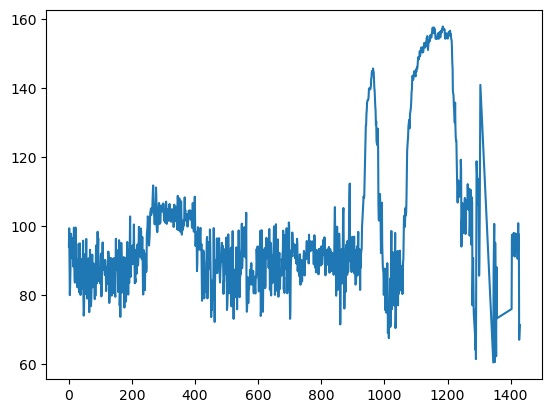

In [7]:
plt.plot(heart_rates[0])

In [298]:
rollings=[i.rolling(50).mean() for i in heart_rates]

([280, 464, 623, 787, 840, 992], [230, 414, 573, 737, 790])

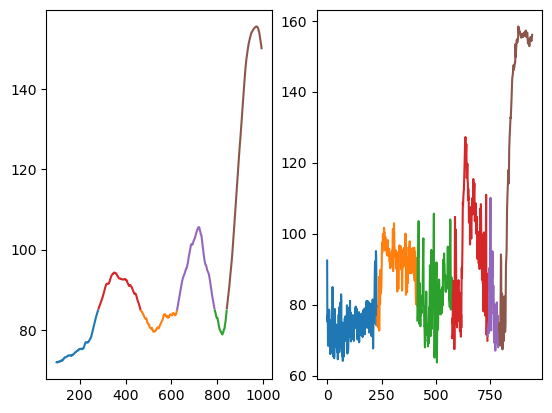

In [266]:
change_in_activity(heart_rates[7], test, bins=[70,85,160], adjustment_factor=-50)

Though this subject isn't that bad, it is not clean like the subject I did in my other single subject notebook. It is hard to tell exactly where the activities start, and though visually we can kind of assume where they start. Using heart rate probably isn't a great strategy...this subject isn't that bad but some others it is almost impossible to tell

See below

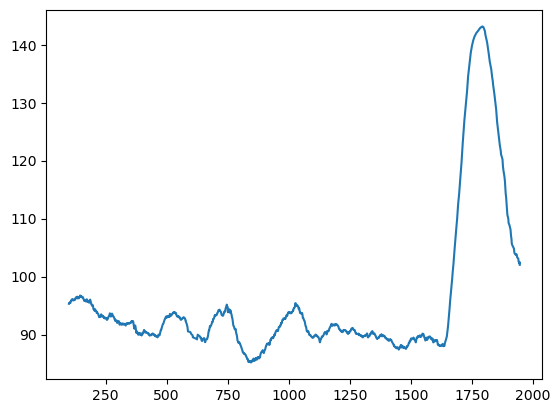

In [12]:
plt.plot(rollings[1])

The data for each of the rollings is a little messy so I am going to see if filtering the data first will help with lceaning up the ECG signals and subseqeuntly the heart rate that the library processes

In [268]:
dfs['FAROS'][]

defaultdict(pandas.core.frame.DataFrame,
            {'x003_FAROS':              time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
             0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
             1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
             2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
             3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
             4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
             ...           ...    ...              ...              ...              ...   
             2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
             2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
             2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
             2859998  285

In [270]:
dfs[key1][key2]['ECG']

0          3077.0
1          3080.0
2          3082.0
3          3088.0
4          3101.0
            ...  
2012995      10.0
2012996      22.0
2012997      12.0
2012998      21.0
2012999      25.0
Name: ECG, Length: 2013000, dtype: float64

In [271]:
b,a =signal.butter(3,(2.5,30), btype='bandpass', fs=1000)
filtered_signals=[]
for key1 in dfs:
    for key2 in dfs[key1]:
        if "FAROS" in key2:
            filtered=signal.filtfilt(b, a, dfs[key1][key2]['ECG'])
            filtered_signals.append(filtered)
        else:
            continue

In [273]:
unitless_FAROS=[(i-np.mean(i))/np.std(i) for i in filtered_signals]

In [274]:
unitless_FAROS[0]

array([-0.16216477, -0.16585394, -0.16939242, ...,  0.11577888,
        0.10463176,  0.09379204])

In [275]:
signals_single,info_single=nk2.ecg_process(unitless_FAROS[0], sampling_rate=1000)

In [282]:
single_test=signals_single['ECG_Rate'][::2000]

In [280]:
single_test

0           93.613336
2000        99.330511
4000        89.121586
6000        79.968218
8000        83.017485
              ...    
2850000     93.965539
2852000     69.306027
2854000     35.282943
2856000    106.310623
2858000     76.852186
Name: ECG_Rate, Length: 1430, dtype: float64

In [283]:
single_invalid=single_test[single_test<60]

In [286]:
single_test=single_test.drop(single_invalid.index)

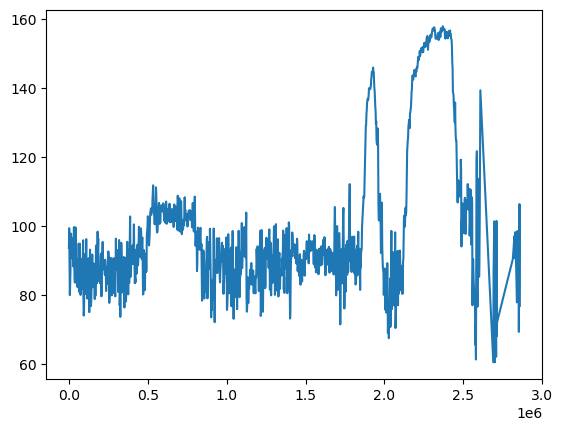

In [288]:
plt.plot(single_test)

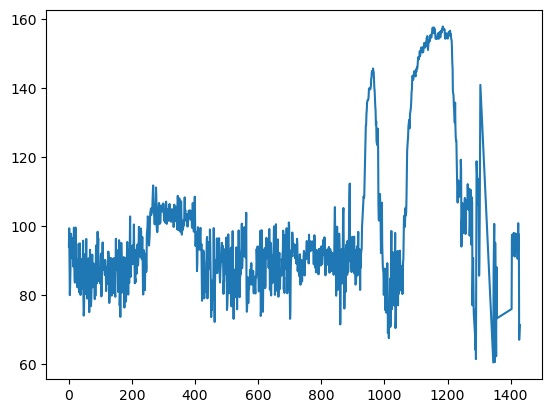

In [289]:
plt.plot(heart_rates[0])

Filtering the ECG signal does not help at all, the graph seems to be identical. So i need another way to try and find out the specific segments for each individual

I could use subject 6 (which had the cleanest data) as a reference index and then align according to subject 6 reference time points and the heart rate data?

Lets try something like that

In [291]:
reference_subject=heart_rates[11]

In [292]:
reference_subject

0        90.044778
1        71.955127
2        70.183319
3        70.558943
4        68.195348
           ...    
1051    110.497238
1052    110.497238
1053    110.497238
1054    110.497238
1055    110.497238
Name: ECG_Rate, Length: 1056, dtype: float64

In [294]:
lengths=[len(i) for i in rollings]

In [295]:
lengths

[1326, 1854, 1355, 1297, 1024, 1098, 1242, 993, 1826, 1254, 800, 1056, 964]

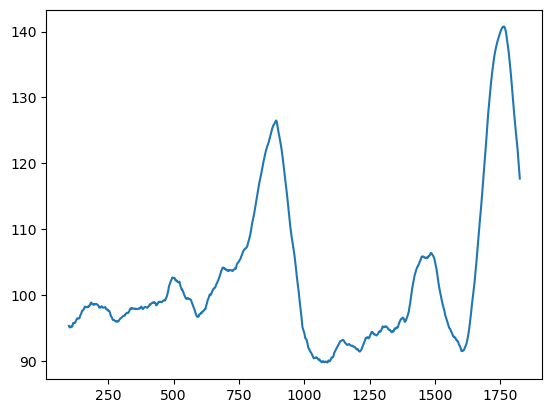

In [174]:
plt.plot(rollings[8])

In [304]:
subject_6[0]

time      ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0         0.000  32767.0     7.595000e+08     2.890000e+08    -5.590000e+08   
1         0.001  32767.0     7.590085e+08     2.854055e+08    -5.609943e+08   
2         0.002  32767.0     7.588405e+08     2.828519e+08    -5.622517e+08   
3         0.003  32767.0     7.589696e+08     2.813497e+08    -5.627896e+08   
4         0.004  32767.0     7.593539e+08     2.808525e+08    -5.626682e+08   
...         ...      ...              ...              ...              ...   
663995  663.995    879.0     7.454370e+08     4.815431e+08    -4.437831e+08   
663996  663.996    881.0     7.476947e+08     4.796316e+08    -4.469024e+08   
663997  663.997    871.0     7.499150e+08     4.777292e+08    -4.501186e+08   
663998  663.998    857.0     7.520119e+08     4.758788e+08    -4.532929e+08   
663999  663.999    859.0     7.538998e+08     4.741227e+08    -4.562928e+08   

              Marker           HRV  DEV_Temperature  
0      -3.276700e+10 -1.455192e-08     2.937351e+07  
1      -3.276700e+10  1.427839e+06     2.937351e+07  
2      -3.276700e+10  2.867822e+06     2.937351e+07  
3      -3.276700e+10  4.319797e+06     2.937351e+07  
4      -3.276700e+10  5.783611e+06     2.937351e+07  
...              ...           ...              ...  
663995 -3.276700e+10  1.316691e+07     3.014891e+07  
663996 -3.276700e+10  1.054767e+07     3.014891e+07  
663997 -3.276700e+10  7.920813e+06     3.014891e+07  
663998 -3.276700e+10  5.286878e+06     3.014891e+07  
663999 -3.276700e+10  2.646422e+06     3.014891e+07  

[664000 rows x 8 columns]

In [330]:
dfs['FAROS']['x003_FAROS']

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
...           ...    ...              ...              ...              ...   
2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
2859998  2859.998   65.0     1.911147e+08     4.668149e+08    -8.375941e+08   
2859999  2859.999   66.0     1.837256e+08     5.039354e+08    -8.222658e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10  2.910383e-08     3.004552e+07  
1       -3.276700e+10  2.342842e+06     3.004552e+07  
2       -3.276700e+10  4.680403e+06     3.004552e+07  
3       -3.276700e+10  7.012191e+06     3.004552e+07  
4       -3.276700e+10  9.337716e+06     3.004552e+07  
...               ...           ...              ...  
2859995 -3.276700e+10  2.128719e+07     2.740915e+07  
2859996 -3.276700e+10  1.700660e+07     2.740915e+07  
2859997 -3.276700e+10  1.273691e+07     2.740915e+07  
2859998 -3.276700e+10  8.478796e+06     2.740915e+07  
2859999 -3.276700e+10  4.232935e+06     2.740915e+07  

[2860000 rows x 8 columns]

In [331]:
dfs_test[0]

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
...           ...    ...              ...              ...              ...   
2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
2859998  2859.998   65.0     1.911147e+08     4.668149e+08    -8.375941e+08   
2859999  2859.999   66.0     1.837256e+08     5.039354e+08    -8.222658e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10  2.910383e-08     3.004552e+07  
1       -3.276700e+10  2.342842e+06     3.004552e+07  
2       -3.276700e+10  4.680403e+06     3.004552e+07  
3       -3.276700e+10  7.012191e+06     3.004552e+07  
4       -3.276700e+10  9.337716e+06     3.004552e+07  
...               ...           ...              ...  
2859995 -3.276700e+10  2.128719e+07     2.740915e+07  
2859996 -3.276700e+10  1.700660e+07     2.740915e+07  
2859997 -3.276700e+10  1.273691e+07     2.740915e+07  
2859998 -3.276700e+10  8.478796e+06     2.740915e+07  
2859999 -3.276700e+10  4.232935e+06     2.740915e+07  

[2860000 rows x 8 columns]

In [ ]:
signals_list

In [319]:
threshold_time=2111
example=dfs_test[0][dfs_test[0]['time']<threshold_time]

In [321]:
len(example)

2111000

In [333]:
signals_list[0]

ECG_Raw   ECG_Clean    ECG_Rate  ECG_Quality  ECG_R_Peaks  \
0          944.0  -82.199082   94.118289     0.998499            0   
1          932.0  -83.739148   94.118289     0.998499            0   
2          929.0  -85.216696   94.118289     0.998499            0   
3          918.0  -86.599212   94.118289     0.998499            0   
4          913.0  -87.814180   94.118289     0.998499            0   
...          ...         ...         ...          ...          ...   
2859995     63.0  124.000051  154.241645     0.981371            0   
2859996     65.0  118.827614  154.241645     0.981371            0   
2859997     66.0  113.653176  154.241645     0.981371            0   
2859998     65.0  108.477226  154.241645     0.981371            0   
2859999     66.0  103.292931  154.241645     0.981371            0   

         ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
0                  0             0              0            0             0   
1                  0             0              0            0             0   
2                  0             0              0            0             0   
3                  0             0              0            0             0   
4                  0             0              0            0             0   
...              ...           ...            ...          ...           ...   
2859995            0             0              0            0             0   
2859996            0             0              0            0             0   
2859997            0             0              0            0             0   
2859998            0             0              0            0             0   
2859999            0             0              0            0             0   

         ECG_R_Offsets  ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  \
0                    0            0            0             0              0   
1                    0            0            0             0              0   
2                    0            0            0             0              0   
3                    0            0            0             0              0   
4                    0            0            0             0              0   
...                ...          ...          ...           ...            ...   
2859995              0            0            0             0              0   
2859996              0            0            0             0              0   
2859997              0            0            0             0              0   
2859998              0            0            0             0              0   
2859999              0            0            0             0              0   

         ECG_Phase_Atrial  ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                     NaN                          0.0                    NaN   
1                     NaN                          0.0                    NaN   
2                     NaN                          0.0                    NaN   
3                     NaN                          0.0                    NaN   
4                     NaN                          0.0                    NaN   
...                   ...                          ...                    ...   
2859995               NaN                          0.0                    NaN   
2859996               NaN                          0.0                    NaN   
2859997               NaN                          0.0                    NaN   
2859998               NaN                          0.0                    NaN   
2859999               NaN                          0.0                    NaN   

         ECG_Phase_Completion_Ventricular  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0

In [326]:
example_test=signals_list[0][:len(example)]

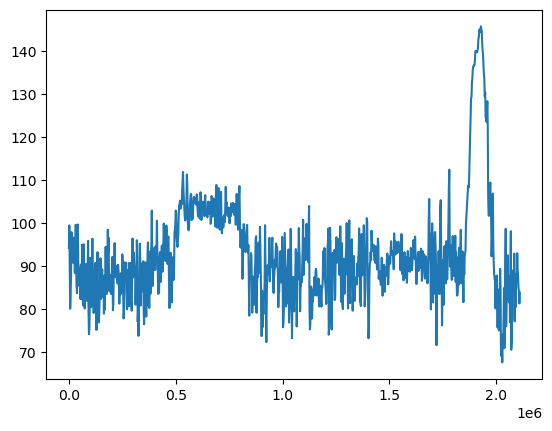

In [328]:
plt.plot(example_test['ECG_Rate'][::2000])

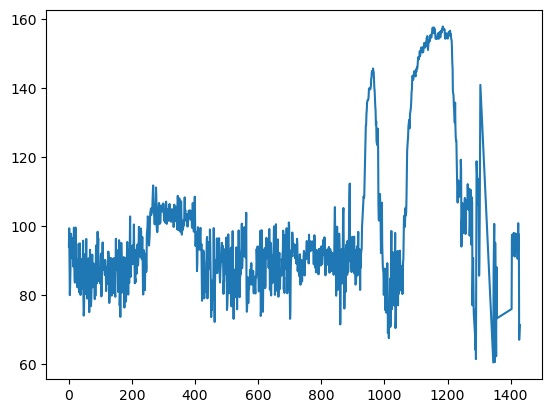

In [329]:
plt.plot(heart_rates[0])

Trying to shorten the length of all the signals ot the length of the reference subject and see if that clarifies any part of the signal

In [177]:
reference_length=len(signals_list[11])

In [178]:
heart_rates_shortened=[i['ECG_Rate'][:reference_length] for i in signals_list] 

In [179]:
heart_rates_shortened

[0          94.118289
 1          94.118289
 2          94.118289
 3          94.118289
 4          94.118289
              ...    
 2110995    84.813362
 2110996    84.817449
 2110997    84.821537
 2110998    84.825627
 2110999    84.829719
 Name: ECG_Rate, Length: 2111000, dtype: float64,
 0          91.846415
 1          91.846415
 2          91.846415
 3          91.846415
 4          91.846415
              ...    
 2110995    92.925785
 2110996    92.919747
 2110997    92.913702
 2110998    92.907649
 2110999    92.901588
 Name: ECG_Rate, Length: 2111000, dtype: float64,
 0          100.738313
 1          100.738313
 2          100.738313
 3          100.738313
 4          100.738313
               ...    
 2110995    114.827378
 2110996    114.828870
 2110997    114.830360
 2110998    114.831847
 2110999    114.833332
 Name: ECG_Rate, Length: 2111000, dtype: float64,
 0           90.612967
 1           90.612967
 2           90.612967
 3           90.612967
 4           90.61296

In [180]:
invalids=[i[i<60] for i in heart_rates_shortened]
invalids=[i.index for i in invalids]
heart_rates_shortened=[i.drop(x) for i,x in zip(heart_rates_shortened, invalids)]

In [181]:
shortened_rolling=[i[::2000] for i in heart_rates_shortened]

In [182]:
shortened_rolling=[i.rolling(100).mean() for i in shortened_rolling]

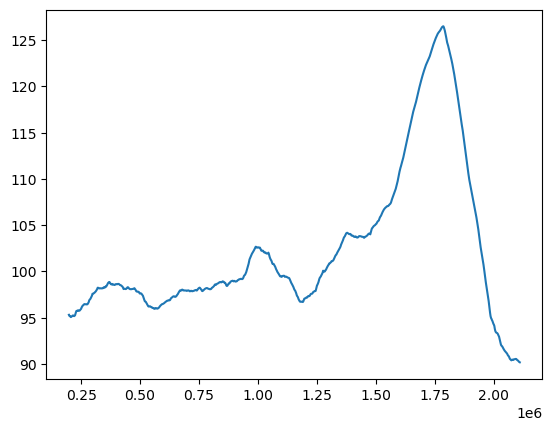

In [183]:
plt.plot(shortened_rolling[8])

# I don't think aligning it with the "shortened_" length is going to work. So I will return to the data of original length and see what can be done there to make sense of the time periods

In [364]:
dfs_test[0]

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
...           ...    ...              ...              ...              ...   
2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
2859998  2859.998   65.0     1.911147e+08     4.668149e+08    -8.375941e+08   
2859999  2859.999   66.0     1.837256e+08     5.039354e+08    -8.222658e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10  2.910383e-08     3.004552e+07  
1       -3.276700e+10  2.342842e+06     3.004552e+07  
2       -3.276700e+10  4.680403e+06     3.004552e+07  
3       -3.276700e+10  7.012191e+06     3.004552e+07  
4       -3.276700e+10  9.337716e+06     3.004552e+07  
...               ...           ...              ...  
2859995 -3.276700e+10  2.128719e+07     2.740915e+07  
2859996 -3.276700e+10  1.700660e+07     2.740915e+07  
2859997 -3.276700e+10  1.273691e+07     2.740915e+07  
2859998 -3.276700e+10  8.478796e+06     2.740915e+07  
2859999 -3.276700e+10  4.232935e+06     2.740915e+07  

[2860000 rows x 8 columns]

In [369]:
heart_rates #the series for ECG_Rate from signals_list [::2000]

[0        94.118289
 1        99.330511
 2        89.121586
 3        79.968218
 4        83.017485
            ...    
 1424    100.814877
 1425     93.014554
 1426     97.560976
 1427     67.032963
 1429     71.326688
 Name: ECG_Rate, Length: 1326, dtype: float64,
 0        91.846415
 1        92.909234
 2        89.408304
 3       101.679057
 4       102.620232
            ...    
 1942     65.199552
 1944    102.345784
 1945    104.362616
 1946    151.933240
 1947     78.476007
 Name: ECG_Rate, Length: 1854, dtype: float64,
 0       100.738313
 1        96.149554
 2        89.423741
 3        87.567477
 4        89.169428
            ...    
 1365     67.608310
 1367    105.532452
 1371     95.870983
 1404     77.600413
 1405     78.255072
 Name: ECG_Rate, Length: 1355, dtype: float64,
 0        90.612967
 1        71.441511
 2        67.593139
 3        65.190497
 4        66.455827
            ...    
 1297    122.674706
 1298     76.424648
 1299     99.123784
 1300    132.590262

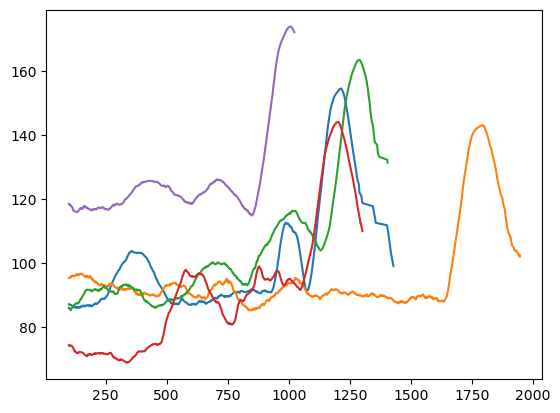

In [374]:
plt.plot(rollings[0])
plt.plot(rollings[1])
plt.plot(rollings[2])
plt.plot(rollings[3])
plt.plot(rollings[4])

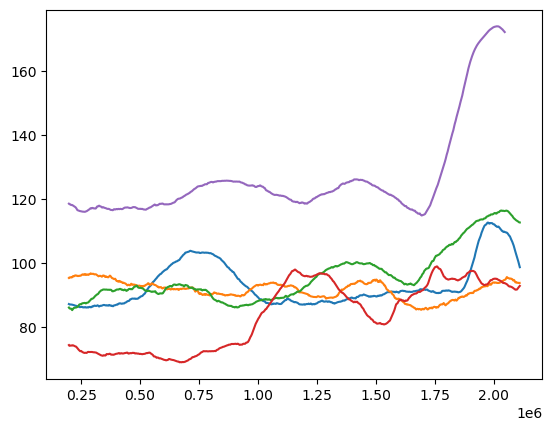

In [184]:
plt.plot(shortened_rolling[0])
plt.plot(shortened_rolling[1])
plt.plot(shortened_rolling[2])
plt.plot(shortened_rolling[3])
plt.plot(shortened_rolling[4])

We see here if I try and just cut it to the length of the reference data, since there is some time overhang at the beginning we never get to the segment where activity increases

 I am going to try and resample each of the signals (dfs_list[ECG]) to the length of the referenence signal (subject 6 heart_rates[11]) so that the rollings all have the same length and compare if it will be easier to assess when the segments begin and end
 
Perhaps I can try another way to align them purely off of heart rate for each individual subject but it is unlikely

In [390]:
test_set=[rollings[0], rollings[1], rollings[2], rollings[3], rollings[4]]

In [395]:
length=len(dfs_test[11])

In [386]:
test_set=[nk2.signal_resample(i, desired_length=1024, desired_sampling_rate=1000) for i in test_set]

In [389]:
test_set[0].size

1024

In [396]:
ECGs=[i['ECG'] for i in dfs_test]

In [398]:
resampled_ECGs=[nk2.signal_resample(i, desired_length=length, desired_sampling_rate=1000) for i in dfs_test]

Mistake here where i resampled all of the columns in all the dataframes instead of just the ECG columns, explored teh data a little but but going back to fix it at next markdown

In [408]:
columns=dfs_test[0].columns

In [431]:
columns=columns.delete([6,7])

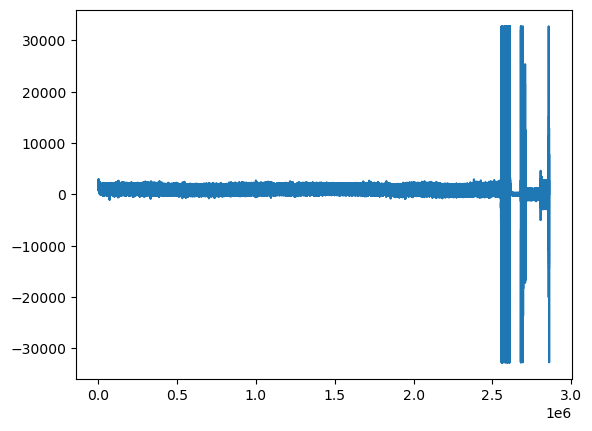

In [436]:
plt.plot(dfs_test[0]['ECG'])

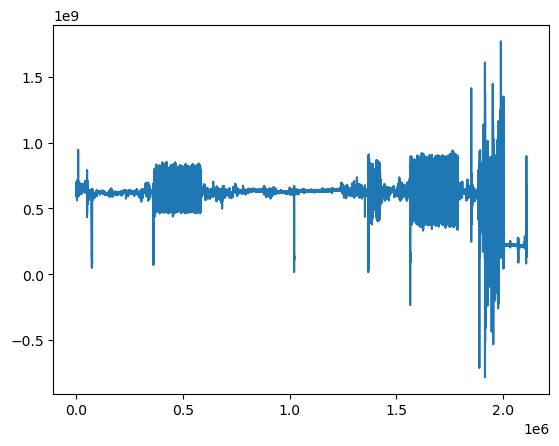

In [445]:
plt.plot(test_2['ECG'])

Can see how much the data changed for whatever reason so clearly fucked somehting up. We can see below the shape of the new resmapled data matches the shape of the original data

Fixing the resampling I did and going to process the data again after I resample the ECGs

# Couple things I am doing now:

1) Trying to remove noise from original ECG signals and then processing and seeing how the rollings and ECG rates look like to see if activities can eb identified from this.
      * Within this, maybe try and define a function that identifies the noise, there are probably libraries for             this as well
        
        
2) Also see if when the resampled_ECGs have been resampled to the len of reference_subject if I can better identify the change in activities     

In [15]:
ECGs=[i['ECG'] for i in dfs_test]

In [16]:
length=len(dfs_test[11])
print(length)

2111000


In [18]:
resampled_ECGs=[nk2.signal_resample(i, desired_length=length, desired_sampling_rate=1000) for i in ECGs]

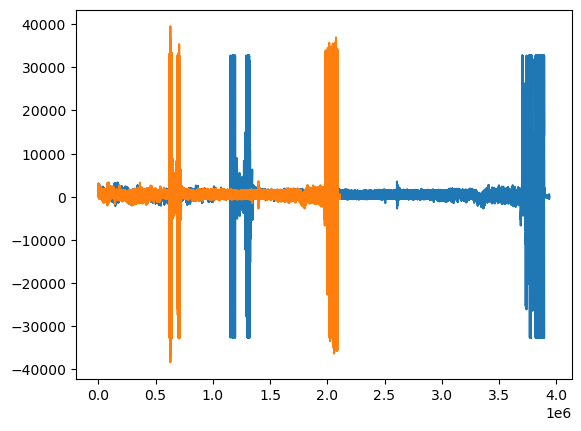

In [22]:
plt.plot(ECGs[1])
plt.plot(resampled_ECGs[1])

In [23]:
test_signals,info=nk2.ecg_process(resampled_ECGs[1], sampling_rate=1000)

In [33]:
test_heart_rate=test_signals['ECG_Rate']

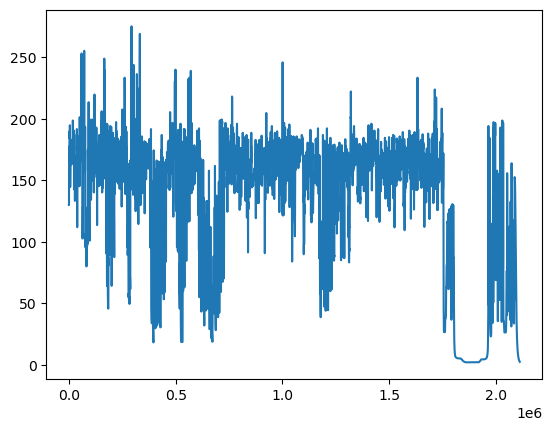

In [31]:
plt.plot(test_heart_rate)

In [32]:
invalids_test=test_heart_rate[test_heart_rate<60].index

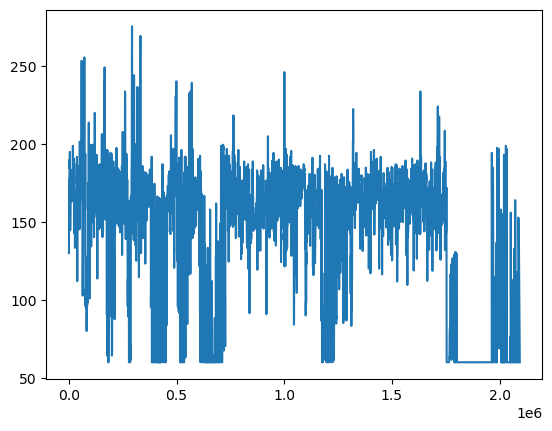

In [38]:
plt.plot(test_heart_rate.drop(invalids_test))

In [40]:
test_heart_rate=test_heart_rate.drop(invalids_test)

In [41]:
test_heart_rate=test_heart_rate[::2000]

In [44]:
heart_rates[1]

0        91.846415
1        92.909234
2        89.408304
3       101.679057
4       102.620232
           ...    
1942     65.199552
1944    102.345784
1945    104.362616
1946    151.933240
1947     78.476007
Name: ECG_Rate, Length: 1854, dtype: float64

In [45]:
test_heart_rate

0          129.991551
2000       166.264902
4000       184.973359
6000       144.582739
8000       170.481912
              ...    
2085321    105.850933
2087789    151.827569
2089789    135.479550
2091789     97.403478
2093789     60.254881
Name: ECG_Rate, Length: 883, dtype: float64

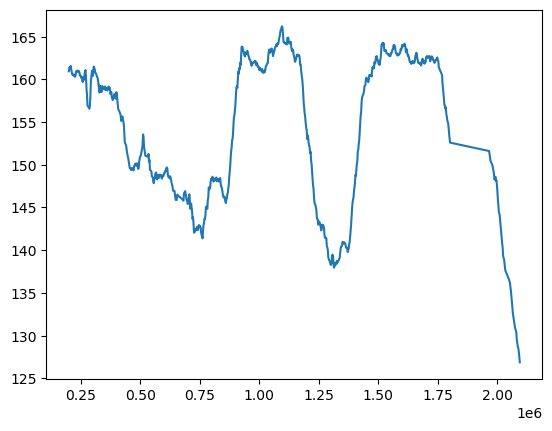

In [48]:
plt.plot(test_heart_rate.rolling(100).mean())

You can see from the above graph that resampling the ECG signal to the length of the desired subject and then processing and attempting to identify activity segments does not work. If anything it has made the signal significantly worse from the original signal in heart_rates[1]

Going to try the second strategy I had which was trying to clean the ECG signal prior to any processing to see if it gets cleaned up a little bit

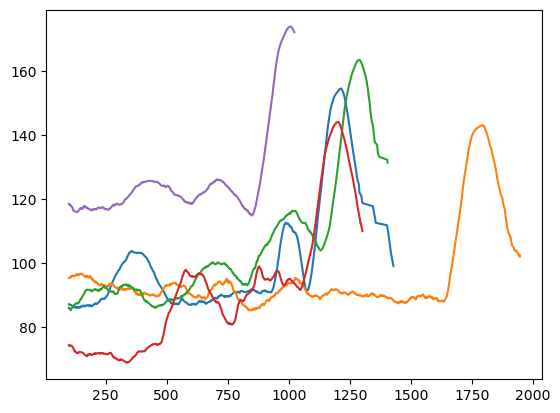

In [49]:
plt.plot(rollings[0])
plt.plot(rollings[1])
plt.plot(rollings[2])
plt.plot(rollings[3])
plt.plot(rollings[4])

Putting this back here as a reminder. The goal is ultimately to try and align these signals so I can better identify the activity segments using heart rate

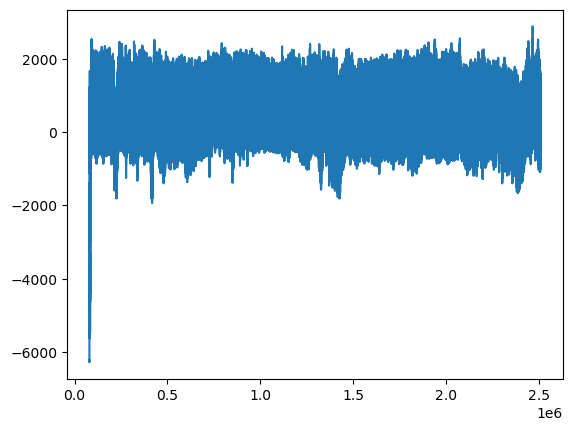

In [59]:
plt.plot(ECGs[9][80000:-70000])

In [60]:
no_noise_test=ECGs[9][80000:-70000]

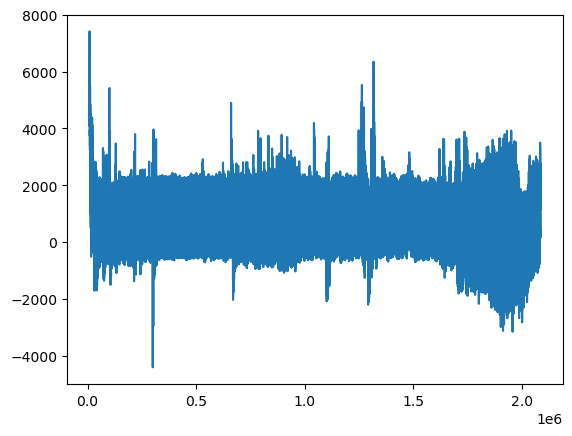

In [61]:
plt.plot(ECGs[11][8000:-25000])

In [62]:
len(no_noise_test)

2428000

In [63]:
len(ECGs[11][8000:-25000])

2078000

In [64]:
reference_test=resampled_ECGs[11][8000:-25000]

In [65]:
tests=[no_noise_test, reference_test]
no_noise_ECGs=[]
for i in tests:
    signals, info=nk2.ecg_process(i, sampling_rate=1000)
    no_noise_ECGs.append(signals)

/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jaredperez/opt/miniconda3/envs/tf/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [68]:
no_noise_heart_rates=[i['ECG_Rate'] for i in no_noise_ECGs]

In [75]:
no_noise_heart_rates=[i[::2000] for i in no_noise_heart_rates]

In [80]:
no_noise_rollings=[i.rolling(100).mean() for i in no_noise_heart_rates]

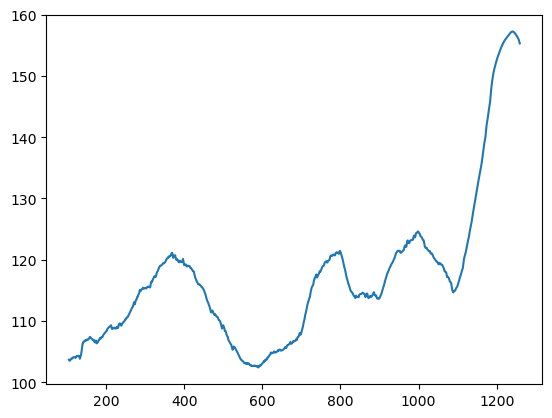

In [81]:
plt.plot(rollings[9])

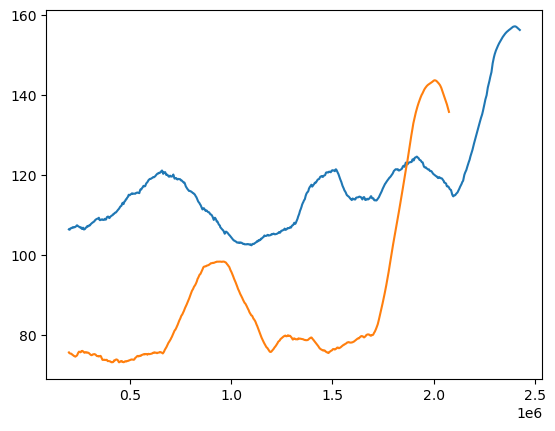

In [195]:
plt.plot(no_noise_rollings[0])
plt.plot(no_noise_rollings[1])

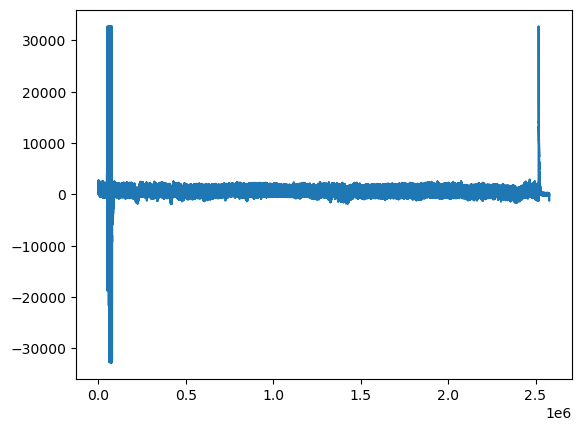

In [87]:
plt.plot(ECGs[9])

In [88]:
clean_test=nk2.ecg_clean(ECGs[9], sampling_rate=1000)

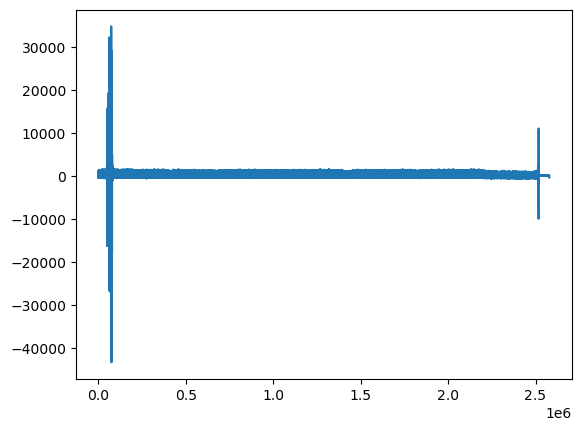

In [89]:
plt.plot(clean_test)

In [95]:
len(clean_test)

2578000

In [94]:
dfs_test[9]

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  779.0     8.730000e+08    -1.800000e+07    -4.435000e+08   
1           0.001  780.0     8.752975e+08    -1.711286e+07    -4.431263e+08   
2           0.002  784.0     8.768343e+08    -1.606840e+07    -4.432897e+08   
3           0.003  778.0     8.775652e+08    -1.488661e+07    -4.438199e+08   
4           0.004  777.0     8.774892e+08    -1.359866e+07    -4.445170e+08   
...           ...    ...              ...              ...              ...   
2577995  2577.995  -87.0     5.466005e+08     1.161032e+06     7.663952e+08   
2577996  2577.996 -112.0     5.940335e+08    -2.390168e+07     7.333780e+08   
2577997  2577.997 -236.0     6.381053e+08    -4.893229e+07     7.023860e+08   
2577998  2577.998 -245.0     6.774304e+08    -7.285545e+07     6.744141e+08   
2577999  2577.999  -61.0     7.109544e+08    -9.466634e+07     6.502638e+08   

               Marker           HRV  DEV_Temperature  
0        3.276600e+10  2.910383e-08     2.642698e+07  
1        3.276600e+10  2.220751e+06     2.642698e+07  
2        3.276600e+10  4.436495e+06     2.642698e+07  
3        3.276600e+10  6.646767e+06     2.642698e+07  
4        3.276600e+10  8.851102e+06     2.642698e+07  
...               ...           ...              ...  
2577995 -3.276700e+10  0.000000e+00     3.175141e+07  
2577996 -3.276700e+10  0.000000e+00     3.175141e+07  
2577997 -3.276700e+10  0.000000e+00     3.175141e+07  
2577998 -3.276700e+10  0.000000e+00     3.175141e+07  
2577999 -3.276700e+10  0.000000e+00     3.175141e+07  

[2578000 rows x 8 columns]

In [96]:
processed_signal,info=nk2.ecg_process(clean_test, sampling_rate=1000)

In [98]:
hr_t=processed_signal['ECG_Rate']

In [100]:
inv_t=hr_t[hr_t<60].index

In [101]:
hr_t=hr_t.drop(inv_t)

In [105]:
hr_t=hr_t[::2000]

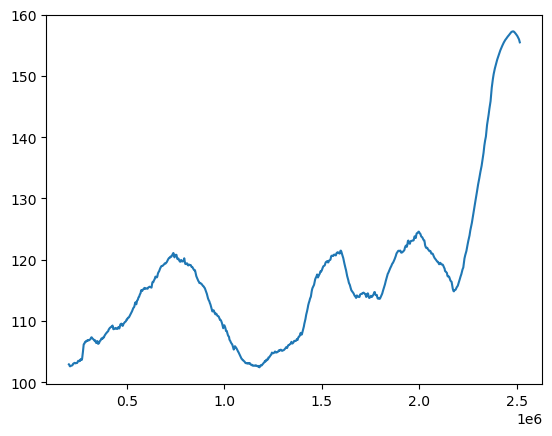

In [106]:
plt.plot(hr_t.rolling(100).mean())

In [109]:
dfs_test[0]

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
...           ...    ...              ...              ...              ...   
2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
2859998  2859.998   65.0     1.911147e+08     4.668149e+08    -8.375941e+08   
2859999  2859.999   66.0     1.837256e+08     5.039354e+08    -8.222658e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10  2.910383e-08     3.004552e+07  
1       -3.276700e+10  2.342842e+06     3.004552e+07  
2       -3.276700e+10  4.680403e+06     3.004552e+07  
3       -3.276700e+10  7.012191e+06     3.004552e+07  
4       -3.276700e+10  9.337716e+06     3.004552e+07  
...               ...           ...              ...  
2859995 -3.276700e+10  2.128719e+07     2.740915e+07  
2859996 -3.276700e+10  1.700660e+07     2.740915e+07  
2859997 -3.276700e+10  1.273691e+07     2.740915e+07  
2859998 -3.276700e+10  8.478796e+06     2.740915e+07  
2859999 -3.276700e+10  4.232935e+06     2.740915e+07  

[2860000 rows x 8 columns]

In [110]:
dfs_test[1]

time     ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  1104.0     8.845000e+08     1.675000e+08    -3.870000e+08   
1           0.001  1089.0     8.856568e+08     1.676658e+08    -3.855404e+08   
2           0.002  1081.0     8.864459e+08     1.678808e+08    -3.850524e+08   
3           0.003  1075.0     8.868800e+08     1.681603e+08    -3.854064e+08   
4           0.004  1076.0     8.869933e+08     1.685129e+08    -3.864258e+08   
...           ...     ...              ...              ...              ...   
3937995  3937.995    -9.0     3.558345e+08    -1.945546e+08    -8.994629e+08   
3937996  3937.996   -15.0     3.769964e+08    -1.517295e+08    -8.891033e+08   
3937997  3937.997     8.0     3.967884e+08    -1.112036e+08    -8.796348e+08   
3937998  3937.998    20.0     4.146518e+08    -7.436522e+07    -8.713823e+08   
3937999  3937.999     7.0     4.301525e+08    -4.235523e+07    -8.646087e+08   

               Marker           HRV  DEV_Temperature  
0        3.276600e+10  7.275958e-09     3.009722e+07  
1        3.276600e+10 -1.180428e+06     3.009722e+07  
2        3.276600e+10 -2.363015e+06     3.009722e+07  
3        3.276600e+10 -3.547510e+06     3.009722e+07  
4        3.276600e+10 -4.733662e+06     3.009722e+07  
...               ...           ...              ...  
3937995 -3.276700e+10  0.000000e+00     2.921843e+07  
3937996 -3.276700e+10  0.000000e+00     2.921843e+07  
3937997 -3.276700e+10  0.000000e+00     2.921843e+07  
3937998 -3.276700e+10  0.000000e+00     2.921843e+07  
3937999 -3.276700e+10  0.000000e+00     2.921843e+07  

[3938000 rows x 8 columns]

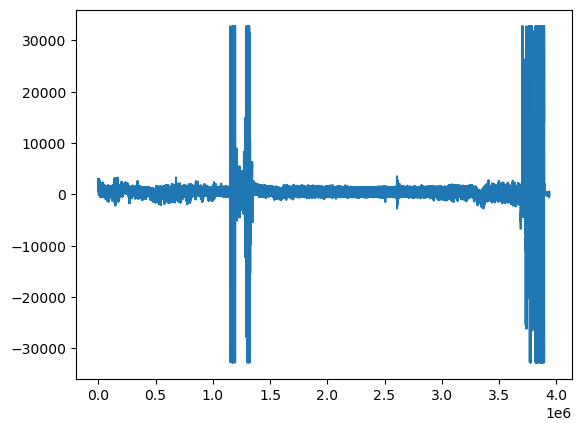

In [113]:
plt.plot(ECGs[1])

In [114]:
clean_test=nk2.ecg_clean(ECGs[1], sampling_rate=1000)
processed_signal,info=nk2.ecg_process(clean_test, sampling_rate=1000)
hr_t=processed_signal['ECG_Rate']
inv_t=hr_t[hr_t<60].index
hr_t=hr_t.drop(inv_t)
hr_t=hr_t[::2000]

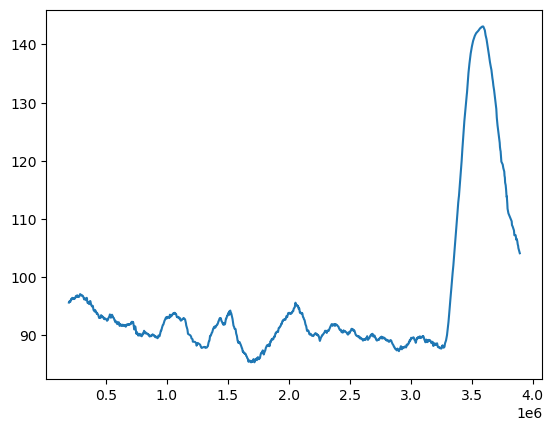

In [119]:
plt.plot(hr_t.rolling(100).mean())

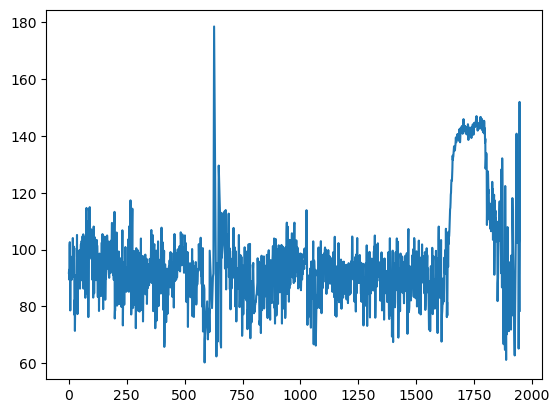

In [118]:
plt.plot(heart_rates[1])

In [123]:
reference_rolls=rollings[11]

In [124]:
len(hr_t.rolling(100).mean())-len(reference_rolls)

783

In [164]:
rolling_test

0                 NaN
2000              NaN
4000              NaN
6000              NaN
8000              NaN
              ...    
3876516    105.650813
3879989    105.390857
3881989    105.009949
3890869    104.340972
3893629    104.114271
Name: ECG_Rate, Length: 1839, dtype: float64

In [191]:
reference_rolls

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1051    132.728891
1052    132.390087
1053    132.055055
1054    131.714244
1055    131.383771
Name: ECG_Rate, Length: 1056, dtype: float64

In [125]:
rolling_test=hr_t.rolling(100).mean()

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2647686523.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(rolling_test[700:])


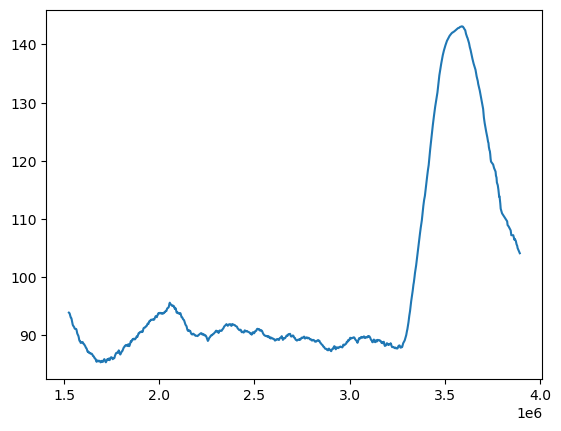

In [127]:
plt.plot(rolling_test[700:])

In [129]:
dfs_test[1]

time     ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  1104.0     8.845000e+08     1.675000e+08    -3.870000e+08   
1           0.001  1089.0     8.856568e+08     1.676658e+08    -3.855404e+08   
2           0.002  1081.0     8.864459e+08     1.678808e+08    -3.850524e+08   
3           0.003  1075.0     8.868800e+08     1.681603e+08    -3.854064e+08   
4           0.004  1076.0     8.869933e+08     1.685129e+08    -3.864258e+08   
...           ...     ...              ...              ...              ...   
3937995  3937.995    -9.0     3.558345e+08    -1.945546e+08    -8.994629e+08   
3937996  3937.996   -15.0     3.769964e+08    -1.517295e+08    -8.891033e+08   
3937997  3937.997     8.0     3.967884e+08    -1.112036e+08    -8.796348e+08   
3937998  3937.998    20.0     4.146518e+08    -7.436522e+07    -8.713823e+08   
3937999  3937.999     7.0     4.301525e+08    -4.235523e+07    -8.646087e+08   

               Marker           HRV  DEV_Temperature  
0        3.276600e+10  7.275958e-09     3.009722e+07  
1        3.276600e+10 -1.180428e+06     3.009722e+07  
2        3.276600e+10 -2.363015e+06     3.009722e+07  
3        3.276600e+10 -3.547510e+06     3.009722e+07  
4        3.276600e+10 -4.733662e+06     3.009722e+07  
...               ...           ...              ...  
3937995 -3.276700e+10  0.000000e+00     2.921843e+07  
3937996 -3.276700e+10  0.000000e+00     2.921843e+07  
3937997 -3.276700e+10  0.000000e+00     2.921843e+07  
3937998 -3.276700e+10  0.000000e+00     2.921843e+07  
3937999 -3.276700e+10  0.000000e+00     2.921843e+07  

[3938000 rows x 8 columns]

In [148]:
accel_test=dfs_test[1][['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]

In [149]:
invalids[1]

Int64Index([ 580,  588,  589,  590,  591,  592,  593,  594,  595,  596,
            ...
            1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968],
           dtype='int64', length=115)

In [150]:
accel_test=accel_test[::2000].reset_index()
accel_test=accel_test.drop(invalids[1])

In [170]:
accel_test=accel_test.drop(columns='index')

In [168]:
rolling_test=rolling_test.reset_index(drop=True)

In [161]:
heart_rates[1].max()

178.4582535181475

Text(0, 0.5, 'ECG_data')

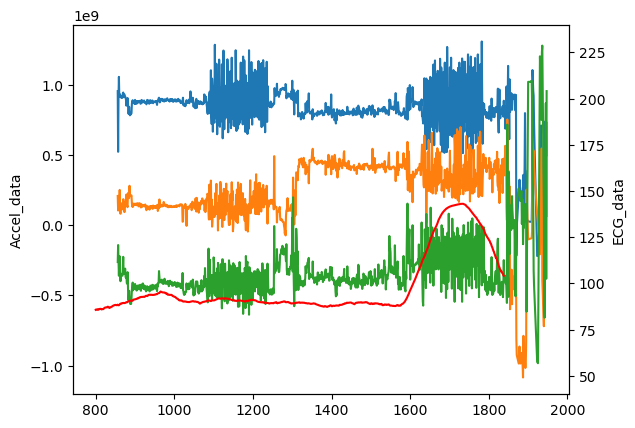

In [227]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(accel_test[800:])
ax1.set_ylabel('Accel_data')

ax2.plot(rolling_test[800:], scaley=False, color='red')
ax2.set_ylim([40,240])
ax2.set_ylabel('ECG_data')

# Now I am trying to use accelerometer data in addition to heart rate data to try and align the segments

    Above we can see that when we start 800 rows in with the accelerometer we can start to differentiate segments (1st: standing, 2nd: walking, 3rd: standing (cognitive test), 4th: uphill walk)

In [196]:
accels=[i[['Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z']]for i in dfs_test]

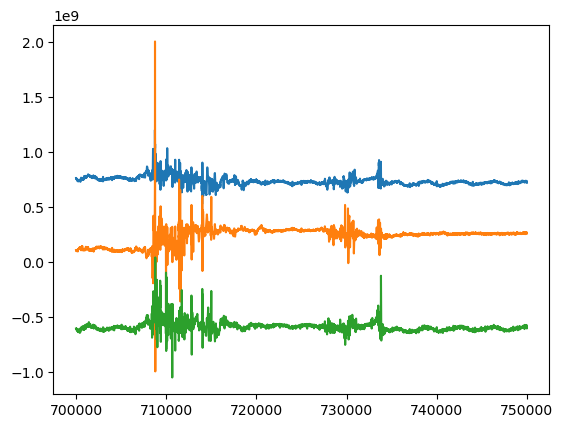

In [214]:
plt.plot(accels[2][700000:750000])

In [216]:
test_segement=accels[2][700000:750000]

In [220]:
test_segement

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
700000     7.635000e+08     1.090000e+08    -6.040000e+08
700001     7.634434e+08     1.083578e+08    -6.054159e+08
700002     7.635195e+08     1.076872e+08    -6.064608e+08
700003     7.637051e+08     1.070088e+08    -6.071594e+08
700004     7.639714e+08     1.063431e+08    -6.075582e+08
...                 ...              ...              ...
749995     7.265057e+08     2.652521e+08    -5.954330e+08
749996     7.253644e+08     2.640934e+08    -5.969109e+08
749997     7.241472e+08     2.629013e+08    -5.981691e+08
749998     7.228986e+08     2.617134e+08    -5.991348e+08
749999     7.216668e+08     2.605674e+08    -5.997550e+08

[50000 rows x 3 columns]

In [226]:
test_segement.iloc[:,0].argmax()

8749

In [223]:
test_segement[8750:8780]

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
708750     1.201000e+09     9.550000e+08    -3.225000e+08
708751     1.193581e+09     1.102708e+09    -3.211973e+08
708752     1.180328e+09     1.256869e+09    -3.233028e+08
708753     1.162517e+09     1.411674e+09    -3.279141e+08
708754     1.141671e+09     1.560771e+09    -3.339345e+08
708755     1.119446e+09     1.697606e+09    -3.401596e+08
708756     1.097498e+09     1.815796e+09    -3.453688e+08
708757     1.077361e+09     1.909492e+09    -3.484187e+08
708758     1.060328e+09     1.973725e+09    -3.483269e+08
708759     1.047357e+09     2.004695e+09    -3.443431e+08
708760     1.039000e+09     2.000000e+09    -3.360000e+08
708761     1.035367e+09     1.958771e+09    -3.231409e+08
708762     1.036129e+09     1.881721e+09    -3.059228e+08
708763     1.040549e+09     1.771085e+09    -2.847947e+08
708764     1.047554e+09     1.630487e+09    -2.604544e+08
708765     1.055829e+09     1.464703e+09    -2.337863e+08
708766     1.063927e+09     1.279373e+09    -2.057879e+08
708767     1.070400e+09     1.080669e+09    -1.774898e+08
708768     1.073915e+09     8.749302e+08    -1.498768e+08
708769     1.073373e+09     6.683207e+08    -1.238162e+08
708770     1.068000e+09     4.665000e+08    -1.000000e+08
708771     1.057412e+09     2.743517e+08    -7.890351e+07
708772     1.041655e+09     9.577637e+07    -6.076587e+07
708773     1.021199e+09    -6.643696e+07    -4.559134e+07
708774     9.969085e+08    -2.106563e+08    -3.317160e+07
708775     9.699740e+08    -3.363693e+08    -2.312608e+07
708776     9.418220e+08    -4.440708e+08    -1.495632e+07
708777     9.140050e+08    -5.350880e+08    -8.108999e+06
708778     8.880827e+08    -6.113599e+08    -2.041752e+06
708779     8.655044e+08    -6.751909e+08     3.714150e+06

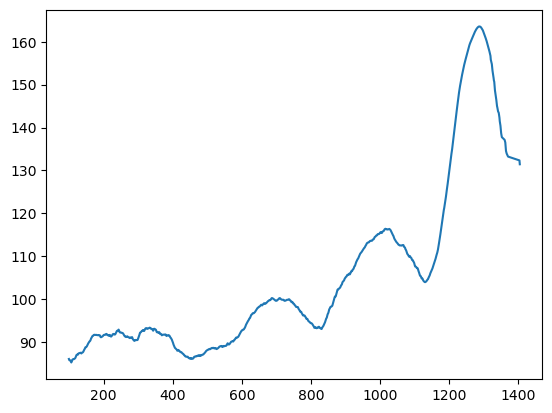

In [224]:
plt.plot(rollings[2])

Define a function that overlays and plots the accel and ECG data so we can better visualize the change in segements and then apply the activity labels

In [230]:
signals_list[0]

ECG_Raw   ECG_Clean    ECG_Rate  ECG_Quality  ECG_R_Peaks  \
0          944.0  -82.199082   94.118289     0.998499            0   
1          932.0  -83.739148   94.118289     0.998499            0   
2          929.0  -85.216696   94.118289     0.998499            0   
3          918.0  -86.599212   94.118289     0.998499            0   
4          913.0  -87.814180   94.118289     0.998499            0   
...          ...         ...         ...          ...          ...   
2859995     63.0  124.000051  154.241645     0.981371            0   
2859996     65.0  118.827614  154.241645     0.981371            0   
2859997     66.0  113.653176  154.241645     0.981371            0   
2859998     65.0  108.477226  154.241645     0.981371            0   
2859999     66.0  103.292931  154.241645     0.981371            0   

         ECG_P_Peaks  ECG_P_Onsets  ECG_P_Offsets  ECG_Q_Peaks  ECG_R_Onsets  \
0                  0             0              0            0             0   
1                  0             0              0            0             0   
2                  0             0              0            0             0   
3                  0             0              0            0             0   
4                  0             0              0            0             0   
...              ...           ...            ...          ...           ...   
2859995            0             0              0            0             0   
2859996            0             0              0            0             0   
2859997            0             0              0            0             0   
2859998            0             0              0            0             0   
2859999            0             0              0            0             0   

         ECG_R_Offsets  ECG_S_Peaks  ECG_T_Peaks  ECG_T_Onsets  ECG_T_Offsets  \
0                    0            0            0             0              0   
1                    0            0            0             0              0   
2                    0            0            0             0              0   
3                    0            0            0             0              0   
4                    0            0            0             0              0   
...                ...          ...          ...           ...            ...   
2859995              0            0            0             0              0   
2859996              0            0            0             0              0   
2859997              0            0            0             0              0   
2859998              0            0            0             0              0   
2859999              0            0            0             0              0   

         ECG_Phase_Atrial  ECG_Phase_Completion_Atrial  ECG_Phase_Ventricular  \
0                     NaN                          0.0                    NaN   
1                     NaN                          0.0                    NaN   
2                     NaN                          0.0                    NaN   
3                     NaN                          0.0                    NaN   
4                     NaN                          0.0                    NaN   
...                   ...                          ...                    ...   
2859995               NaN                          0.0                    NaN   
2859996               NaN                          0.0                    NaN   
2859997               NaN                          0.0                    NaN   
2859998               NaN                          0.0                    NaN   
2859999               NaN                          0.0                    NaN   

         ECG_Phase_Completion_Ventricular  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0

In [232]:
heart_rates[0]

0        94.118289
1        99.330511
2        89.121586
3        79.968218
4        83.017485
           ...    
1424    100.814877
1425     93.014554
1426     97.560976
1427     67.032963
1429     71.326688
Name: ECG_Rate, Length: 1326, dtype: float64

In [242]:
new_accel=accels[0][::2000]
new_accel=new_accel.reset_index(drop=True)

Text(0, 0.5, 'ECG_data')

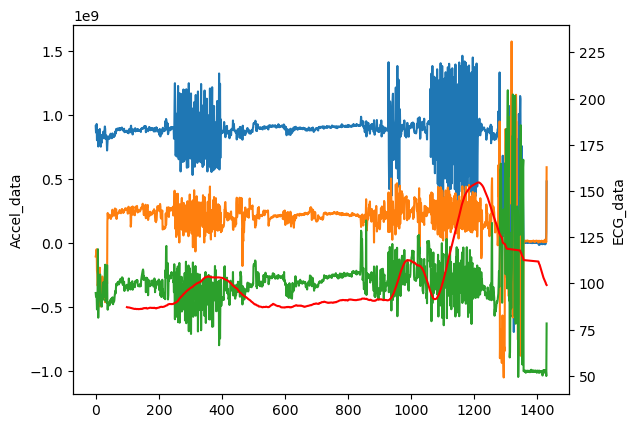

In [244]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(new_accel)
ax1.set_ylabel('Accel_data')

ax2.plot(rollings[0], scaley=False, color='red')
ax2.set_ylim([40,240])
ax2.set_ylabel('ECG_data')

In [263]:
sliced_accels=[i[::2000].reset_index(drop=True) for i in accels]

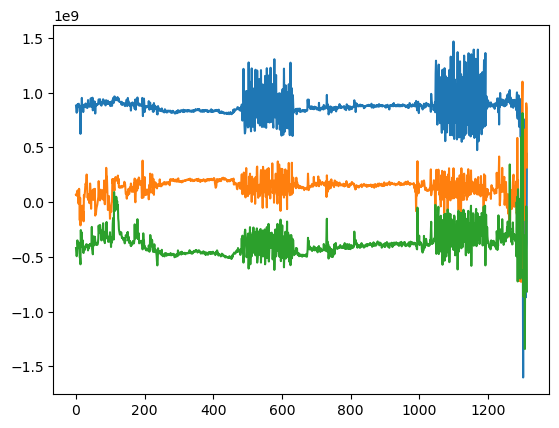

In [267]:
plt.plot(sliced_accels[3])

In [778]:
def determine_slice_factor(accel_data, heart_rate_data, rolling_data, start_slice_factor=None, end_slice_factor=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(accel_data[start_slice_factor:end_slice_factor])
    ax1.set_ylabel('Accel_data')

    ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
    ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')
    ax2.set_ylim([40,240])
    ax2.set_ylabel('ECG_data')
    
    return start_slice_factor, end_slice_factor

In [372]:
invalids

[Int64Index([], dtype='int64'),
 Int64Index([1155427, 1155428, 1155429, 1155430, 1155431, 1155432, 1155433,
             1155434, 1155435, 1155436,
             ...
             1328607, 1328608, 1328609, 1328610, 1328611, 1328612, 1328613,
             1328614, 1328615, 1328616],
            dtype='int64', length=113262),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([], dtype='int64'),
 Int64Index([ 244479,  244480,  244481,  244482,  244483,  244484,  244485,
              244486,  244487,  244488,
             ...
             1347001, 1347002, 1347003, 1347004, 1347005, 1347006, 1347007,
             1347008, 1347009, 1347010],
            dtype='int64', length=51465),
 Int64Index([], dtype='int64'),
 Int64Index([1984862, 1984863, 1984864, 1984865, 1984866, 1984867, 1984868,
             1984869, 1984870, 1984871,
             ...
             2047990, 2047991, 2047992, 2047993, 2047994, 2047995, 2047996,
             2047997, 2047998, 2047999],
     

In [371]:
sliced_accels

[      Accelerometer_X  Accelerometer_Y  Accelerometer_Z
 0        9.100000e+08     -107500000.0    -3.930000e+08
 1        8.610000e+08      -94000000.0    -4.220000e+08
 2        8.865000e+08      -62500000.0    -4.025000e+08
 3        9.275000e+08      -51000000.0    -4.200000e+08
 4        8.005000e+08     -219000000.0    -5.215000e+08
 ...               ...              ...              ...
 1425    -1.200000e+07       13500000.0    -1.016000e+09
 1426    -8.000000e+06        9500000.0    -1.010000e+09
 1427    -9.094947e-09       11500000.0    -1.006000e+09
 1428     8.550000e+07        5500000.0    -1.041500e+09
 1429     4.785000e+08      589500000.0    -6.310000e+08
 
 [1430 rows x 3 columns],
       Accelerometer_X  Accelerometer_Y  Accelerometer_Z
 0         884500000.0      167500000.0    -3.870000e+08
 1         865000000.0      224500000.0    -4.435000e+08
 2         849500000.0      189000000.0    -4.495000e+08
 3         871000000.0      160000000.0    -4.455000e+08
 4 

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


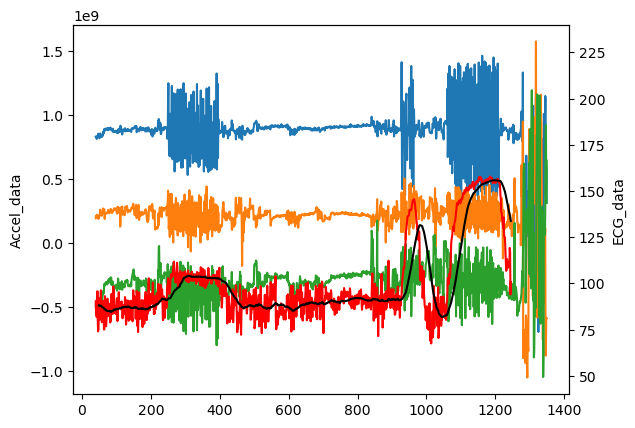

In [370]:
slice_factors_1=visualize_accel_ECG(sliced_accels[0], heart_rates[0], rollings[0], start_slice_factor=40, end_slice_factor=-80)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


(900, None)

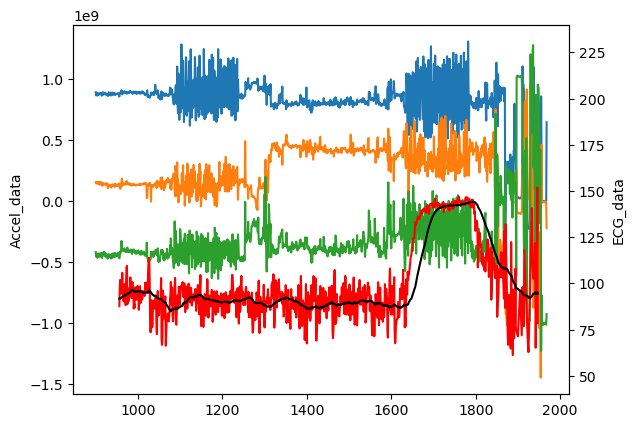

In [368]:
visualize_accel_ECG(sliced_accels[1], heart_rates[1], rollings[1], start_slice_factor=900)

Goal here is to get the first 5 rollings along with the first 5 accelerometers data to visualize so I can assess how much data i need to cut off each subject

In [351]:
test_segement=sliced_accels[1][900:1200]

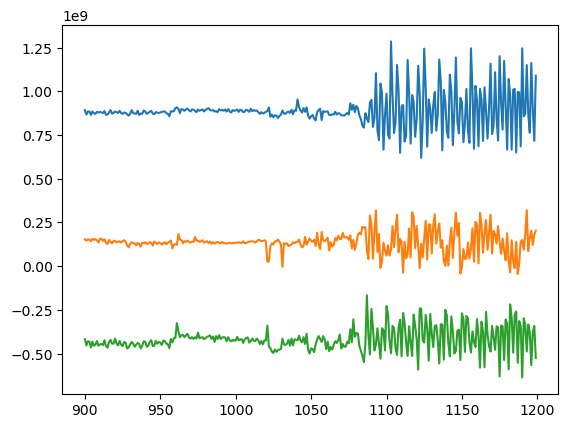

In [352]:
plt.plot(test_segement)

In [359]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [348]:
test_segement=pd.DataFrame(StandardScaler().fit_transform(test_segement))

In [360]:
standardized_mean=StandardScaler().fit_transform(test_segement.iloc[:,0].values.reshape(-1,1))

In [361]:
standardized_max=preprocessing.MinMaxScaler().fit_transform(test_segement)

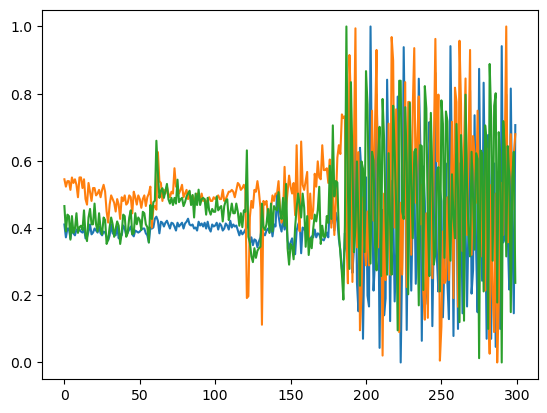

In [362]:
plt.plot(standardized_max)

In [318]:
heart_rates[1]

0        91.846415
1        92.909234
2        89.408304
3       101.679057
4       102.620232
           ...    
1942     65.199552
1944    102.345784
1945    104.362616
1946    151.933240
1947     78.476007
Name: ECG_Rate, Length: 1854, dtype: float64

IndexError: index -1 is out of bounds for axis 0 with size 0

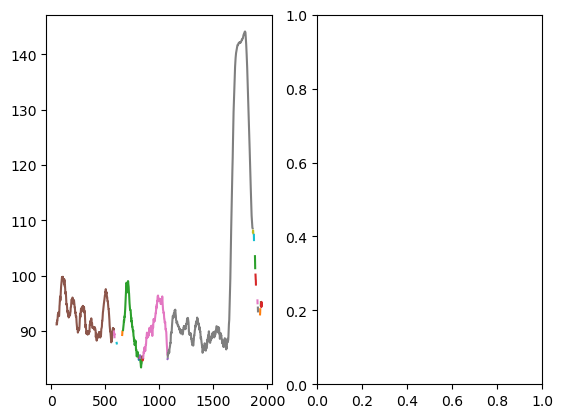

In [339]:
change_in_activity(heart_rates[1], rollings[1], bins=[70,85,160])

# Going to manually go through the subjects to assess where their data starts and ends, then I will try and find a better way to automate it

First need to remove from accels the invalids that were recorded with improper/inapparopriate heart rates....was done up above in earlier cell

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


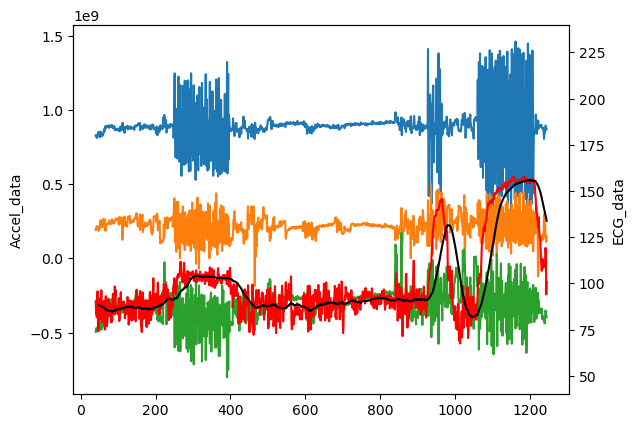

In [392]:
s_0_adjustment=visualize_accel_ECG(sliced_accels[0], heart_rates[0], rollings[0], start_slice_factor=40, end_slice_factor=-80)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


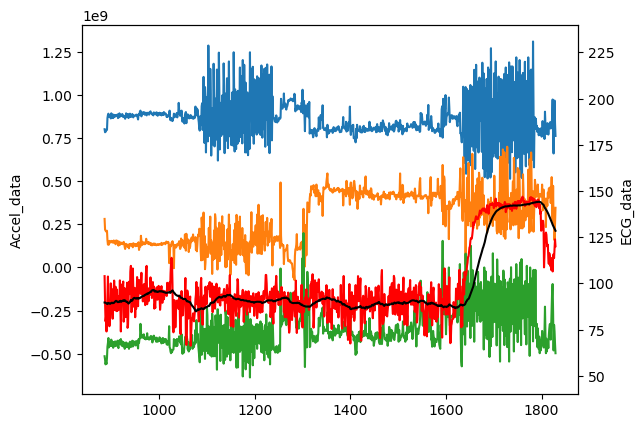

In [399]:
s_1_adjustment=visualize_accel_ECG(sliced_accels[1], heart_rates[1], rollings[1], start_slice_factor=830, end_slice_factor=-80)

(None, None)

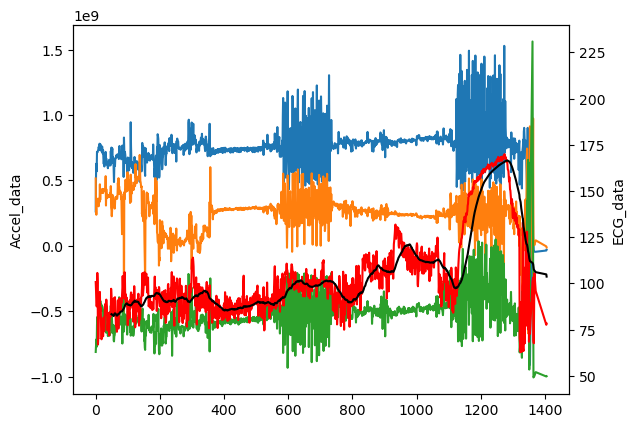

In [400]:
visualize_accel_ECG(sliced_accels[2], heart_rates[2], rollings[2])

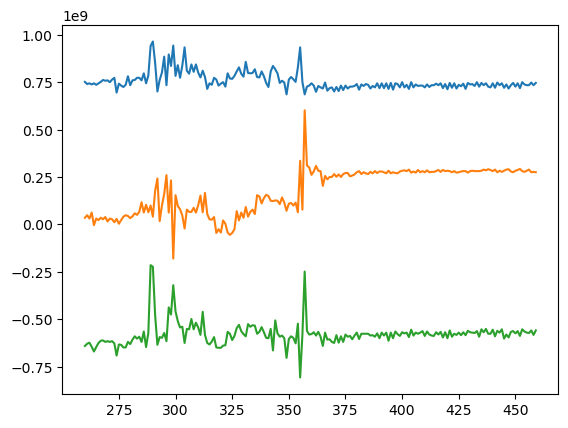

In [407]:
plt.plot(sliced_accels[2][260:460])

In [409]:
test=sliced_accels[2][260:460]

In [438]:
test=test.round(1)

In [413]:
diffs=sliced_accels[2].diff()

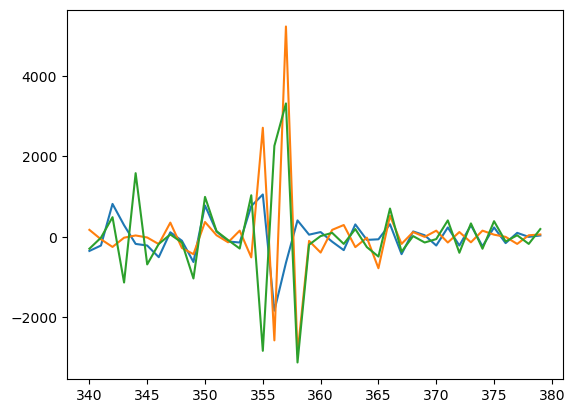

In [448]:
plt.plot(diffs[340:380].iloc[:,].round(1)/100000)

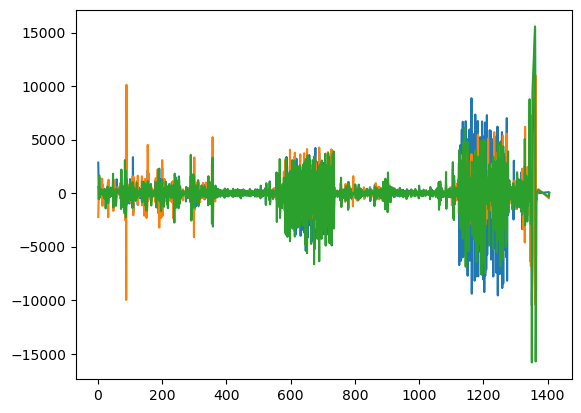

In [428]:
plt.plot(diffs/100000)

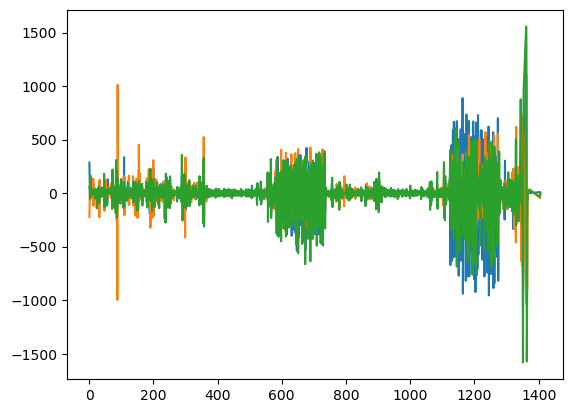

In [453]:
plt.plot(diffs.round(1)/1000000)

In [664]:
diffs

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
0                 NaN              NaN              NaN
1        2.850000e+08     -223000000.0       57000000.0
2        8.000000e+07      -54500000.0       39000000.0
3       -5.850000e+07       84000000.0      -56500000.0
4        1.485000e+08       39000000.0      166000000.0
...               ...              ...              ...
1365    -6.850000e+07      -54500000.0        6000000.0
1367    -5.500000e+06      -12000000.0        5500000.0
1371     7.450581e-09       37000000.0       29500000.0
1404     9.500000e+06      -46500000.0      -33500000.0
1405     6.000000e+06       -8000000.0        2000000.0

[1355 rows x 3 columns]

In [665]:
test=diffs.round(1)/1000000

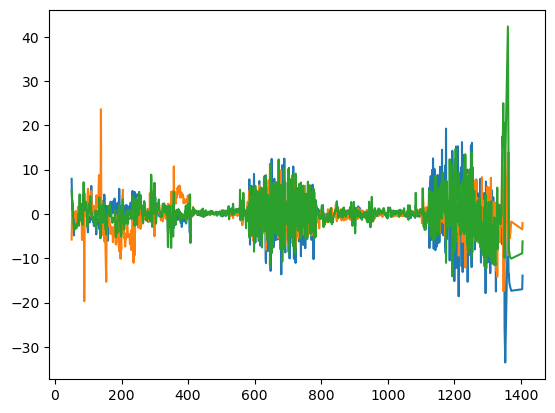

In [466]:
plt.plot(test.rolling(50).mean())

In [470]:
test[test>10]

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
0                 NaN              NaN              NaN
1               285.0              NaN             57.0
2                80.0              NaN             39.0
3                 NaN             84.0              NaN
4               148.5             39.0            166.0
...               ...              ...              ...
1365              NaN              NaN              NaN
1367              NaN              NaN              NaN
1371              NaN             37.0             29.5
1404              NaN              NaN              NaN
1405              NaN              NaN              NaN

[1355 rows x 3 columns]

In [482]:
import scipy

In [485]:
scipy.stats.entropy(test['Accelerometer_Z'])

nan

In [491]:
test.max()-test.min()

Accelerometer_X    2598.0
Accelerometer_Y    2135.5
Accelerometer_Z    3139.0
dtype: float64

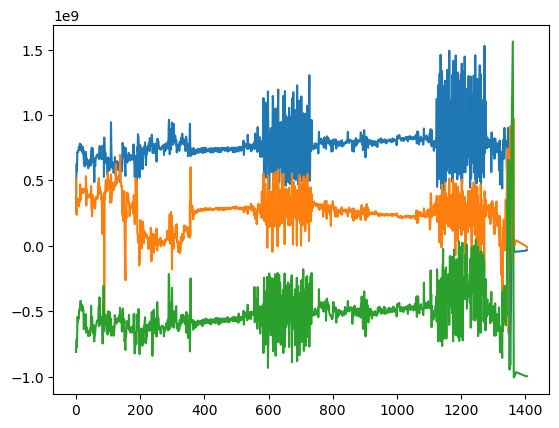

In [493]:
plt.plot(sliced_accels[2])

In [505]:
step=100
ranges_2=[]
for x in range(0,len(sliced_accels[2]), step):
    r=test.iloc[x:x+step].max()-test.iloc[x:x+step].min()
    ranges_2.append(r)

In [510]:
step=100
ranges_2=[]
for x in range(0,len(sliced_accels[2]), step):
    r=test.iloc[x:x+step].max()-test.iloc[x:x+step].min()
    ranges_2.append(r)

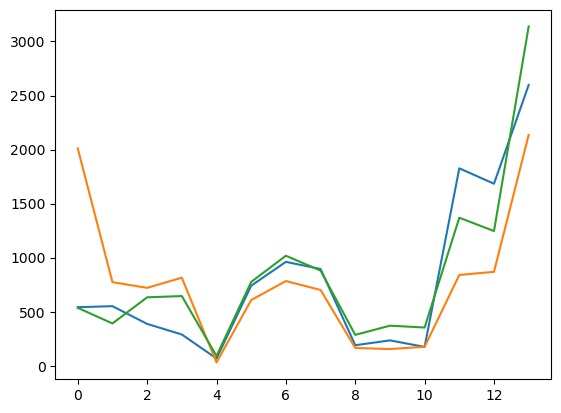

In [512]:
plt.plot(ranges_2)

In [513]:
test_2=sliced_accels[6]

In [522]:
test_2_diff=sliced_accels[6].diff()
test_2_diff=test_2_diff/1000000

In [523]:
step=100
ranges_3=[]
for x in range(0,len(sliced_accels[6]), step):
    r=test_2_diff.iloc[x:x+step].max()-test_2_diff.iloc[x:x+step].min()
    ranges_3.append(r)

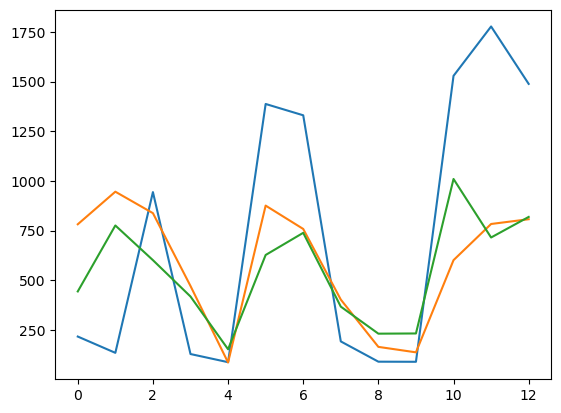

In [524]:
plt.plot(ranges_3)

In [521]:
threshold=
ranges_3

[Accelerometer_X    216500000.0
 Accelerometer_Y    781500000.0
 Accelerometer_Z    443500000.0
 dtype: float64,
 Accelerometer_X    134500000.0
 Accelerometer_Y    945500000.0
 Accelerometer_Z    775500000.0
 dtype: float64,
 Accelerometer_X    943500000.0
 Accelerometer_Y    837500000.0
 Accelerometer_Z    601000000.0
 dtype: float64,
 Accelerometer_X    128500000.0
 Accelerometer_Y    471000000.0
 Accelerometer_Z    418000000.0
 dtype: float64,
 Accelerometer_X     87500000.0
 Accelerometer_Y     86000000.0
 Accelerometer_Z    152500000.0
 dtype: float64,
 Accelerometer_X    1.387000e+09
 Accelerometer_Y    8.755000e+08
 Accelerometer_Z    6.270000e+08
 dtype: float64,
 Accelerometer_X    1.330000e+09
 Accelerometer_Y    7.580000e+08
 Accelerometer_Z    7.385000e+08
 dtype: float64,
 Accelerometer_X    192000000.0
 Accelerometer_Y    402500000.0
 Accelerometer_Z    367000000.0
 dtype: float64,
 Accelerometer_X     90000000.0
 Accelerometer_Y    164500000.0
 Accelerometer_Z    231000

In [506]:
ranges #A list of ranges of accel values for every 100 values in sliced_accels[2]

[Accelerometer_X    5.645000e+08
 Accelerometer_Y    1.164500e+09
 Accelerometer_Z    5.060000e+08
 dtype: float64,
 Accelerometer_X    455000000.0
 Accelerometer_Y    957000000.0
 Accelerometer_Z    355500000.0
 dtype: float64,
 Accelerometer_X    379000000.0
 Accelerometer_Y    439500000.0
 Accelerometer_Z    625000000.0
 dtype: float64,
 Accelerometer_X    248000000.0
 Accelerometer_Y    656500000.0
 Accelerometer_Z    558500000.0
 dtype: float64,
 Accelerometer_X    43000000.0
 Accelerometer_Y    29500000.0
 Accelerometer_Z    59000000.0
 dtype: float64,
 Accelerometer_X    762000000.0
 Accelerometer_Y    566500000.0
 Accelerometer_Z    695500000.0
 dtype: float64,
 Accelerometer_X    857500000.0
 Accelerometer_Y    628500000.0
 Accelerometer_Z    681500000.0
 dtype: float64,
 Accelerometer_X    822500000.0
 Accelerometer_Y    549000000.0
 Accelerometer_Z    625000000.0
 dtype: float64,
 Accelerometer_X    164000000.0
 Accelerometer_Y    148500000.0
 Accelerometer_Z    287000000.0


In [508]:
len(sliced_accels[2])/100

13.55

In [509]:
len(ranges)

14

In [525]:
rollings[2]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1365    107.637353
1367    106.963779
1371    106.071820
1404    104.879291
1405    103.672951
Name: ECG_Rate, Length: 1355, dtype: float64

In [526]:
heart_rates[2]

0       100.738313
1        96.149554
2        89.423741
3        87.567477
4        89.169428
           ...    
1365     67.608310
1367    105.532452
1371     95.870983
1404     77.600413
1405     78.255072
Name: ECG_Rate, Length: 1355, dtype: float64

In [737]:
subject_df=pd.concat([sliced_accels[2], heart_rates[2], rollings[2]], axis=1)

In [531]:
subject_df=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(subject_df))

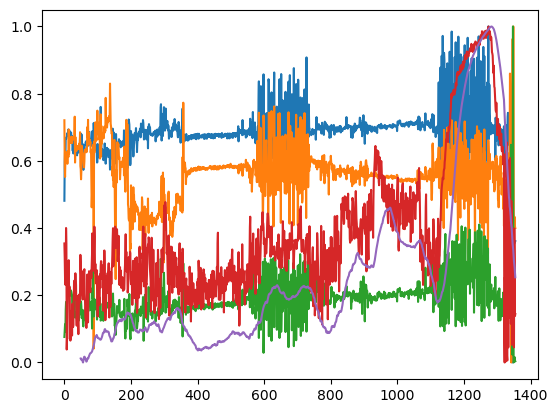

In [533]:
plt.plot(subject_df)

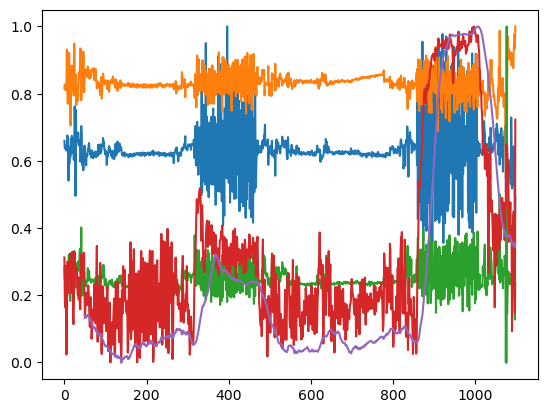

In [534]:
subject_df_2=pd.concat([sliced_accels[5], heart_rates[5], rollings[5]], axis=1)
subject_df_2=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(subject_df_2))
plt.plot(subject_df_2)

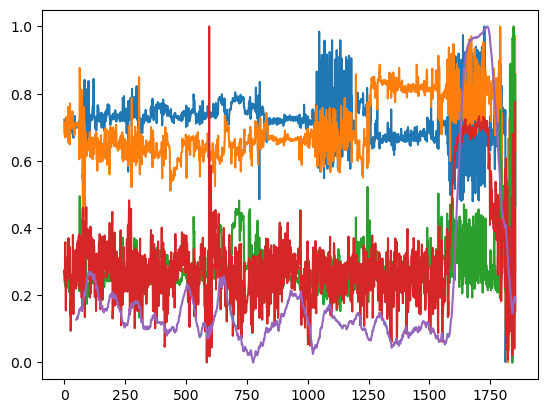

In [535]:
subject_df_3=pd.concat([sliced_accels[1], heart_rates[1], rollings[1]], axis=1)
subject_df_3=pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(subject_df_3))
plt.plot(subject_df_3)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


(830, -80)

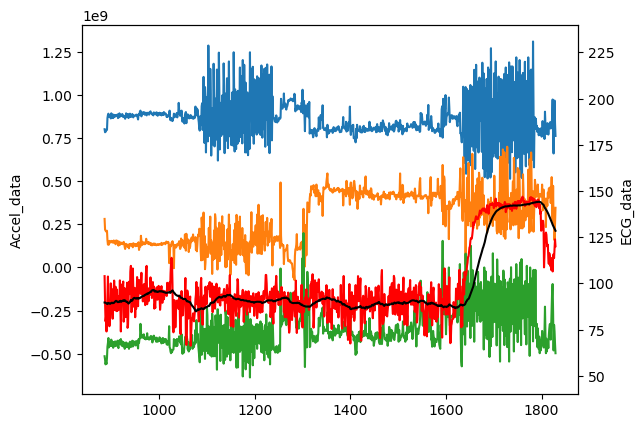

In [536]:
visualize_accel_ECG(sliced_accels[1], heart_rates[1], rollings[1], start_slice_factor=830, end_slice_factor=-80)

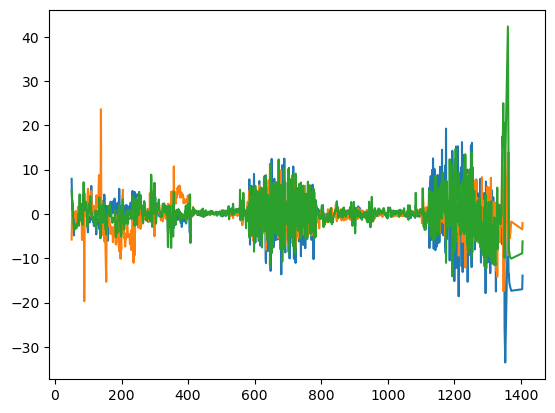

In [541]:
plt.plot(test.rolling(50).mean())

In [542]:
test

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
0                 NaN              NaN              NaN
1               285.0           -223.0             57.0
2                80.0            -54.5             39.0
3               -58.5             84.0            -56.5
4               148.5             39.0            166.0
...               ...              ...              ...
1365            -68.5            -54.5              6.0
1367             -5.5            -12.0              5.5
1371              0.0             37.0             29.5
1404              9.5            -46.5            -33.5
1405              6.0             -8.0              2.0

[1355 rows x 3 columns]

In [578]:
test=test.round(1)/1000000

In [582]:
step = 100
ranges_2 = []
for x in range(0, len(test), step):
    segment = test.iloc[x:x+step]
    segment_range = segment.max() - segment.min()
    if (segment_range < 500).all():
        ranges_2.append(segment)

# Combine the segments into a single DataFrame
result = pd.concat(ranges_2)

In [583]:
ranges_2

[     Accelerometer_X  Accelerometer_Y  Accelerometer_Z
 400             27.5              4.0             19.5
 401            -27.5              2.0             -6.0
 402             13.5             -4.0              4.0
 403            -21.5              8.0            -23.5
 404             35.5            -16.0             39.0
 ..               ...              ...              ...
 495            -31.5             -0.0            -29.5
 496             35.0             -9.5             19.5
 497            -25.0             11.5            -23.5
 498             21.5             -5.5             17.5
 499            -25.5             13.5            -11.5
 
 [100 rows x 3 columns],
      Accelerometer_X  Accelerometer_Y  Accelerometer_Z
 800            -17.5             39.0              8.0
 801             80.0            -27.5             80.0
 802              9.5            -15.5             41.0
 803            -19.5            -23.5            -51.0
 804              2.0

Problem with this above technique is this is just some arbitrary absolute value. I need to find a method that is relative to each subject. 

Something like, when the values exceed a certain percentage of their values, then the label for it changes, but that still does not answer the problem of when to "start" the data (i.e when does the data collection actually start and not include noise from beginning)

In [661]:
test['sum']=test.sum

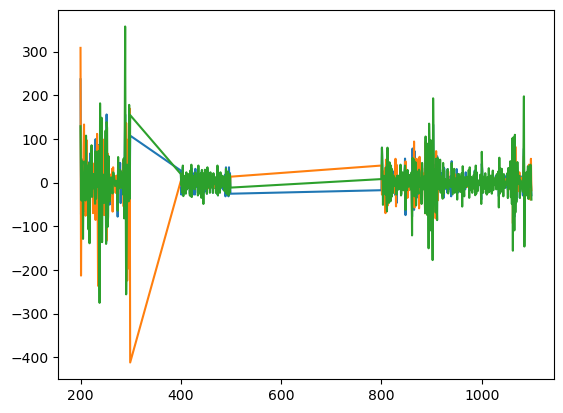

In [569]:
plt.plot(result)

In [572]:
np.array(result.index)

array([ 200,  201,  202,  203,  204,  205,  206,  207,  208,  209,  210,
        211,  212,  213,  214,  215,  216,  217,  218,  219,  220,  221,
        222,  223,  224,  225,  226,  227,  228,  229,  230,  231,  232,
        233,  234,  235,  236,  237,  238,  239,  240,  241,  242,  243,
        244,  245,  246,  247,  248,  249,  250,  251,  252,  253,  254,
        255,  256,  257,  258,  259,  260,  261,  262,  263,  264,  265,
        266,  267,  268,  269,  270,  271,  272,  273,  274,  275,  276,
        277,  278,  279,  280,  281,  282,  283,  284,  285,  286,  287,
        288,  289,  290,  291,  292,  293,  294,  295,  296,  297,  298,
        299,  400,  401,  402,  403,  404,  405,  406,  407,  408,  409,
        410,  411,  412,  413,  414,  415,  416,  417,  418,  419,  420,
        421,  422,  423,  424,  425,  426,  427,  428,  429,  430,  431,
        432,  433,  434,  435,  436,  437,  438,  439,  440,  441,  442,
        443,  444,  445,  446,  447,  448,  449,  4

(None, None)

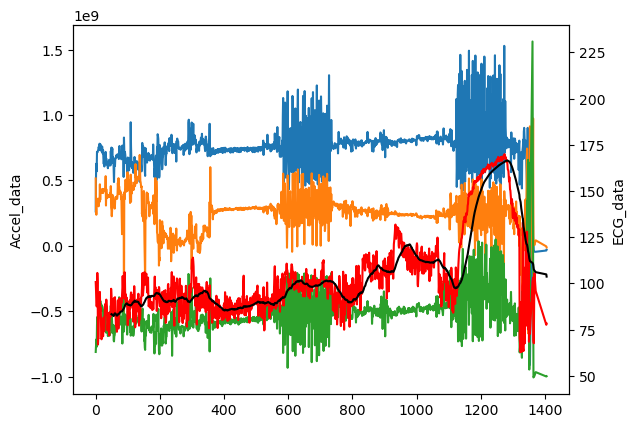

In [544]:
visualize_accel_ECG(sliced_accels[2], heart_rates[2], rollings[2])

In [564]:
test=sliced_accels[2].diff()

(None, None)

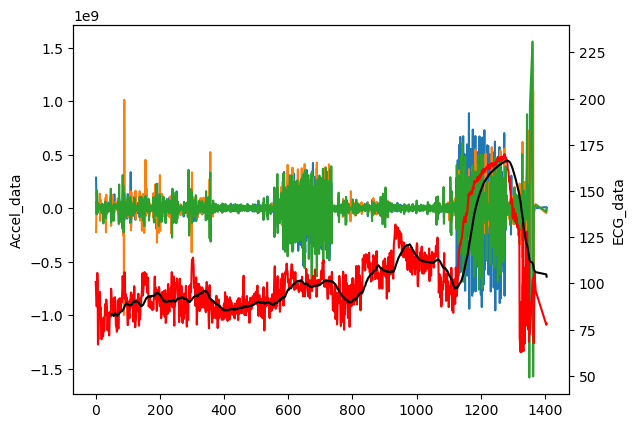

In [565]:
visualize_accel_ECG(test, heart_rates[2], rollings[2])

In [643]:
normalized_accel=subject_df_3.iloc[:,:3]

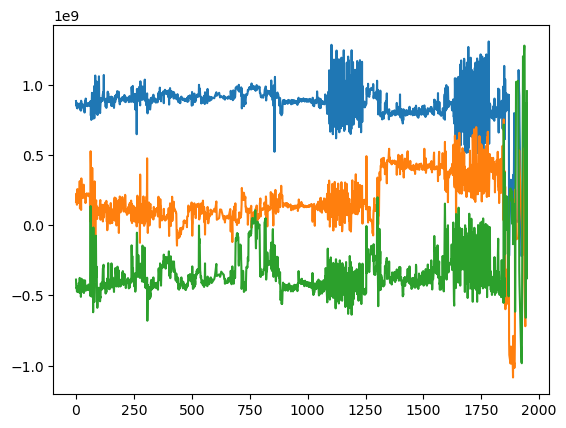

In [655]:
plt.plot(sliced_accels[1])

Trying Kmeans algorithim to see if it can cluster signals together into a similar pattern....unsuccesful

In [656]:
clustering_kmeans, clusters_kmeans, info = nk2.cluster(sliced_accels[1], method='kmeans', n_clusters=3)

In [657]:
clustering_kmeans[clustering_kmeans['Cluster']==0].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1807, 1808, 1809, 1810, 1811, 1812, 1840, 1841, 1848, 1849],
           dtype='int64', length=1269)

In [617]:
clusters_kmeans

array([[-19.31761006,  -3.79716981,  -7.5       ],
       [  5.66873065,  -3.47987616,   1.37616099],
       [  5.61025641,   7.50769231,   3.36025641]])

In [628]:
modes=[]
for i in range(0, len(clustering_kmeans), 10):
    mode=scipy.stats.mode(clustering_kmeans['Cluster'])[0][0]
    modes.append(mode)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/199368765.py:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode=scipy.stats.mode(clustering_kmeans['Cluster'])[0][0]


In [630]:
scipy.stats.energy_distance

136

In [658]:
dfs_test[0]

time    ECG  Accelerometer_X  Accelerometer_Y  Accelerometer_Z  \
0           0.000  944.0     9.100000e+08    -1.075000e+08    -3.930000e+08   
1           0.001  932.0     9.074109e+08    -1.146383e+08    -3.902630e+08   
2           0.002  929.0     9.039169e+08    -1.205736e+08    -3.876677e+08   
3           0.003  918.0     8.996692e+08    -1.251890e+08    -3.853900e+08   
4           0.004  913.0     8.948533e+08    -1.284129e+08    -3.836073e+08   
...           ...    ...              ...              ...              ...   
2859995  2859.995   63.0     2.176424e+08     3.316306e+08    -8.900691e+08   
2859996  2859.996   65.0     2.083789e+08     3.791407e+08    -8.721528e+08   
2859997  2859.997   66.0     1.994288e+08     4.247461e+08    -8.544347e+08   
2859998  2859.998   65.0     1.911147e+08     4.668149e+08    -8.375941e+08   
2859999  2859.999   66.0     1.837256e+08     5.039354e+08    -8.222658e+08   

               Marker           HRV  DEV_Temperature  
0       -3.276700e+10  2.910383e-08     3.004552e+07  
1       -3.276700e+10  2.342842e+06     3.004552e+07  
2       -3.276700e+10  4.680403e+06     3.004552e+07  
3       -3.276700e+10  7.012191e+06     3.004552e+07  
4       -3.276700e+10  9.337716e+06     3.004552e+07  
...               ...           ...              ...  
2859995 -3.276700e+10  2.128719e+07     2.740915e+07  
2859996 -3.276700e+10  1.700660e+07     2.740915e+07  
2859997 -3.276700e+10  1.273691e+07     2.740915e+07  
2859998 -3.276700e+10  8.478796e+06     2.740915e+07  
2859999 -3.276700e+10  4.232935e+06     2.740915e+07  

[2860000 rows x 8 columns]

In [666]:
test['sum']=np.sum(test, axis=0)

In [671]:
test=test.drop(columns='sum')

In [677]:
test['sum']=test.sum(axis=1)

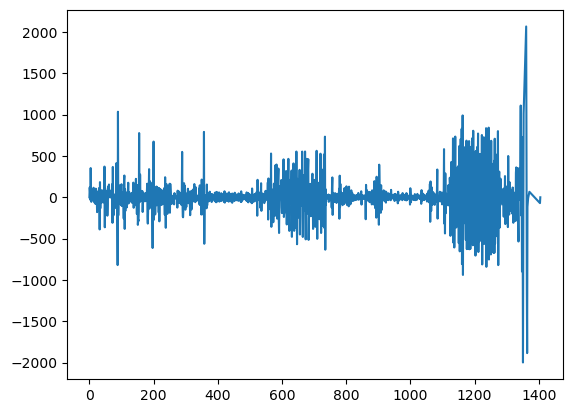

In [679]:
plt.plot(test['sum'])

In [682]:
test['sum'].max()

2066.5

In [683]:
test['sum'].min()

-1998.5

In [684]:
scipy.stats.describe(test['sum'])

DescribeResult(nobs=1355, minmax=(-1998.5, 2066.5), mean=-0.7424354243542436, variance=57739.022607062834, skewness=-0.10962630349034014, kurtosis=13.205090294751653)

In [685]:
q1, q3 = np.percentile(test['sum'], [25, 75])

In [693]:
test['sum'][test['sum']<q1]

6        -55.0
16       -64.5
19       -80.5
24      -179.5
27       -90.0
         ...  
1351   -1998.5
1363   -1095.5
1364   -1885.0
1365    -117.0
1404     -70.5
Name: sum, Length: 338, dtype: float64

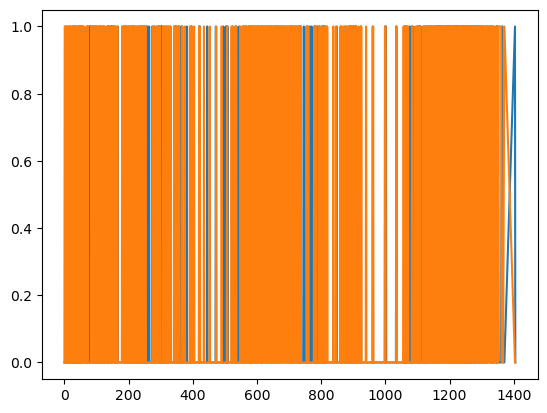

In [694]:
plt.plot(test['sum']<q1)
plt.plot(test['sum']>q3)

In [695]:
q3

51.0

In [696]:
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = [x for x in test['sum'] if x < lower_bound or x > upper_bound]

In [706]:
pd.Series(outliers)

0       353.5
1      -389.0
2       371.5
3      -363.0
4      -222.5
        ...  
259   -1998.5
260    1012.0
261    2066.5
262   -1095.5
263   -1885.0
Length: 264, dtype: float64

In [707]:
no_outliers=test['sum'][~test['sum'].isin(outliers)]

In [708]:
no_outliers

0         0.0
1       119.0
2        64.5
3       -31.0
5        56.5
        ...  
1365   -117.0
1367    -12.0
1371     66.5
1404    -70.5
1405      0.0
Name: sum, Length: 1091, dtype: float64

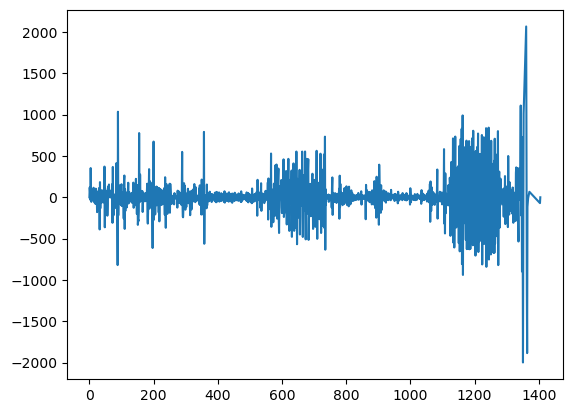

In [710]:
plt.plot(test['sum'])

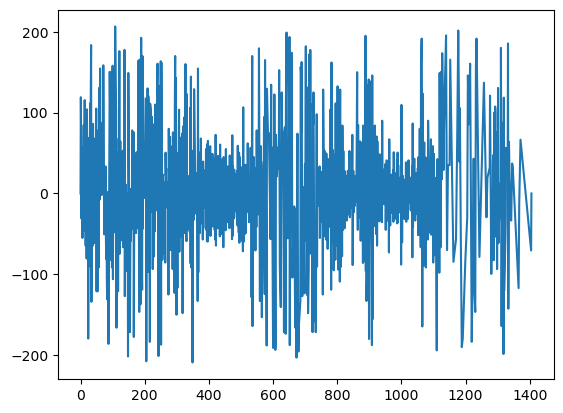

In [709]:
plt.plot(no_outliers)

In [713]:
index_greater=no_outliers[no_outliers>q3].index
index_less=no_outliers[no_outliers<q1].index

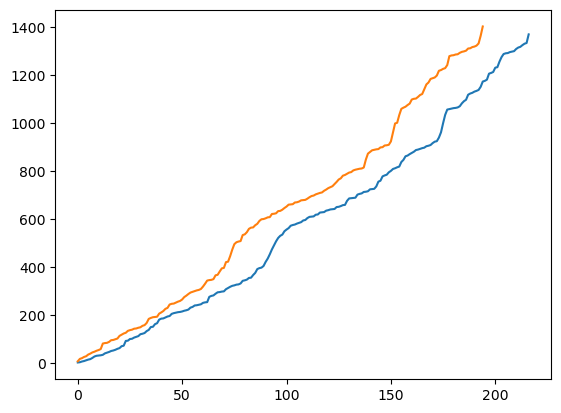

In [714]:
plt.plot(index_greater)
plt.plot(index_less)

In [723]:
greater=pd.concat([pd.Series(index_greater), pd.Series(np.ones(217))], axis=1)

In [725]:
greater.index=greater[0]

In [728]:
greater=greater.drop(columns=0)

In [729]:
greater.index

Int64Index([   1,    2,    5,    7,   10,   13,   15,   20,   26,   29,
            ...
            1297, 1299, 1301, 1310, 1316, 1319, 1326, 1332, 1335, 1371],
           dtype='int64', name=0, length=217)

In [731]:
less=pd.concat([pd.Series(index_less), pd.Series(np.zeros(195))], axis=1)

In [733]:
less.index=less[0]
less=less.drop(columns=0)

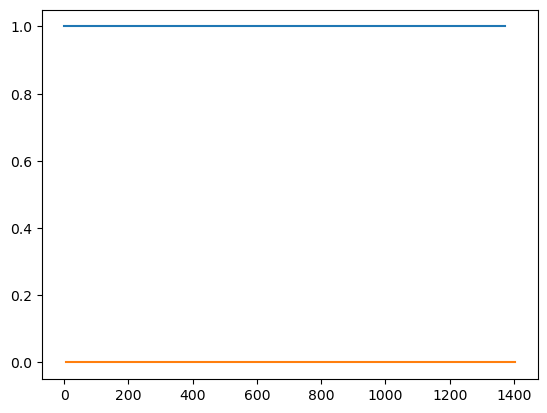

In [735]:
plt.plot(greater)
plt.plot(less)

In [738]:
subject_df

Accelerometer_X  Accelerometer_Y  Accelerometer_Z    ECG_Rate  \
0         263500000.0      515500000.0    -8.110000e+08  100.738313   
1         548500000.0      292500000.0    -7.540000e+08   96.149554   
2         628500000.0      238000000.0    -7.150000e+08   89.423741   
3         570000000.0      322000000.0    -7.715000e+08   87.567477   
4         718500000.0      361000000.0    -6.055000e+08   89.169428   
...               ...              ...              ...         ...   
1365      -39500000.0       17500000.0    -1.000000e+09   67.608310   
1367      -45000000.0        5500000.0    -9.945000e+08  105.532452   
1371      -45000000.0       42500000.0    -9.650000e+08   95.870983   
1404      -35500000.0       -4000000.0    -9.985000e+08   77.600413   
1405      -29500000.0      -12000000.0    -9.965000e+08   78.255072   

        ECG_Rate  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
1365  107.637353  
1367  106.963779  
1371  106.071820  
1404  104.879291  
1405  103.672951  

[1355 rows x 5 columns]

In [742]:
accel_test

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
0         884500000.0      167500000.0     -387000000.0
1         865000000.0      224500000.0     -443500000.0
2         849500000.0      189000000.0     -449500000.0
3         871000000.0      160000000.0     -445500000.0
4         835500000.0      146000000.0     -473000000.0
...               ...              ...              ...
1942      205000000.0     -338000000.0     -658500000.0
1944      740000000.0      486000000.0      427500000.0
1945      628500000.0     -240500000.0      869000000.0
1946      736000000.0      703000000.0     -381000000.0
1947      498000000.0       66000000.0      955000000.0

[1854 rows x 3 columns]

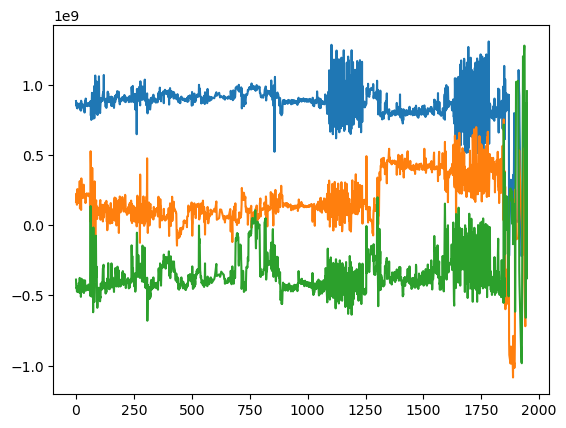

In [753]:
plt.plot(accel_test)

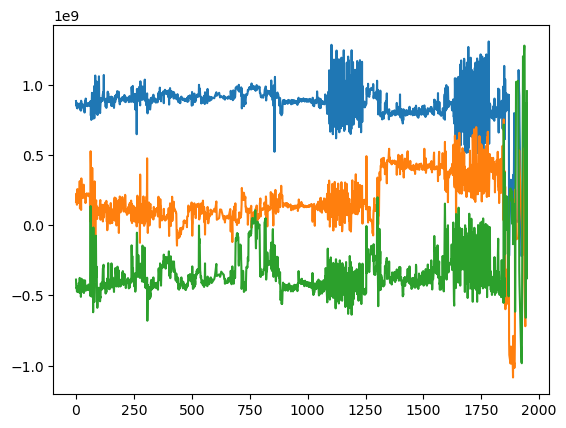

In [747]:
plt.plot(sliced_accels[1])

In [754]:
s_1_adjustment.

(830, -80)

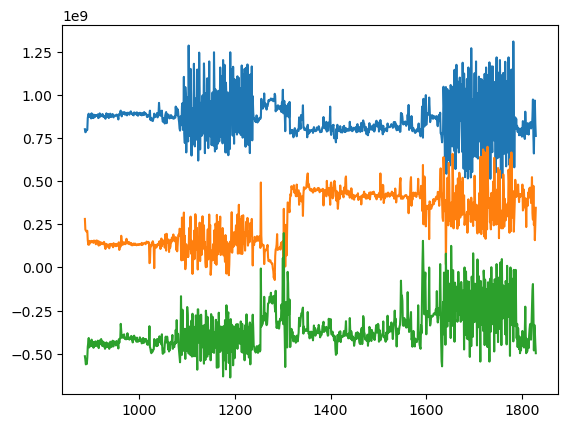

In [757]:
plt.plot(accel_test[830:-80])

# I am kind of at a loss here, so what I am going to do instead is manually get all the segments for say 6 subjects, then define a function that analyses the accelerometer data based on some charachteristics in the data (mean, variance, etc) and then apply that function to the rest of the data and see if it can classify accordingly..

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


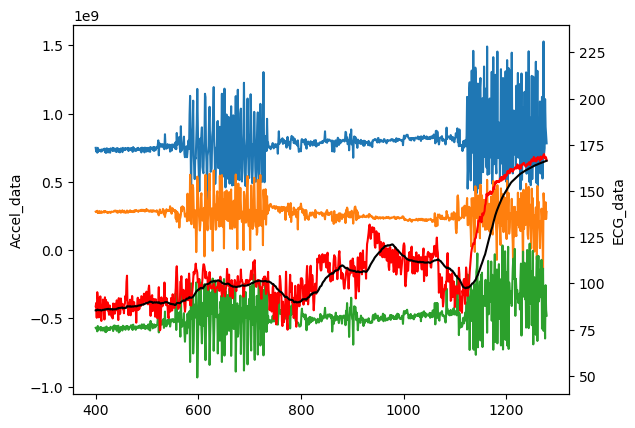

In [762]:
s_2_adjustments=visualize_accel_ECG(sliced_accels[2], heart_rates[2], rollings[2], start_slice_factor=400, end_slice_factor=-75)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


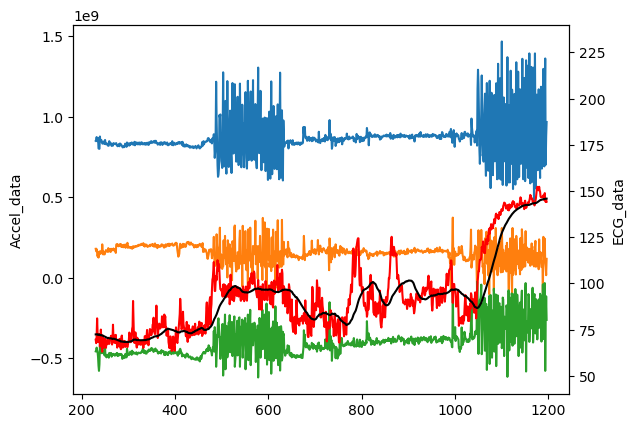

In [767]:
s_3_adj=visualize_accel_ECG(sliced_accels[3], heart_rates[3], rollings[3], start_slice_factor=230, end_slice_factor=-100)

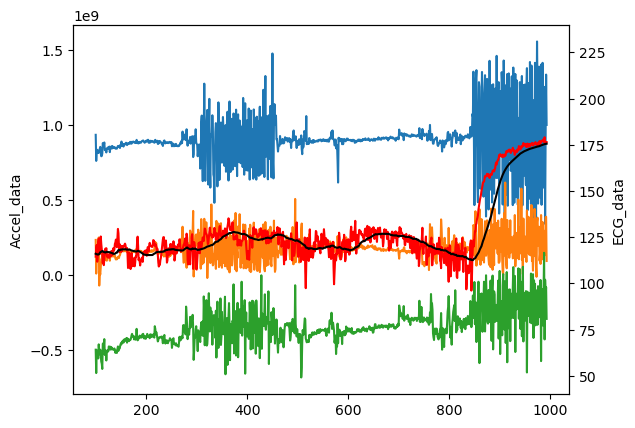

In [769]:
s_4_adj=visualize_accel_ECG(sliced_accels[4], heart_rates[4], rollings[4], start_slice_factor=100, end_slice_factor=-30)

/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
/var/folders/wv/c3g7vgxd10n0mdl2_flcjj480000gn/T/ipykernel_902/2020004717.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')


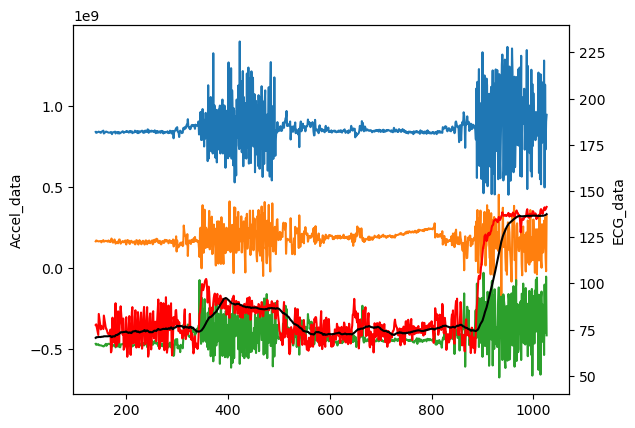

In [774]:
s_5_adj=visualize_accel_ECG(sliced_accels[5], heart_rates[5], rollings[5], start_slice_factor=140, end_slice_factor=-100)

In [775]:
train_adjustments=[s_0_adjustment, s_1_adjustment, s_2_adjustments, s_3_adj, s_4_adj, s_5_adj]

In [777]:
s_0_adjustment[0]

40

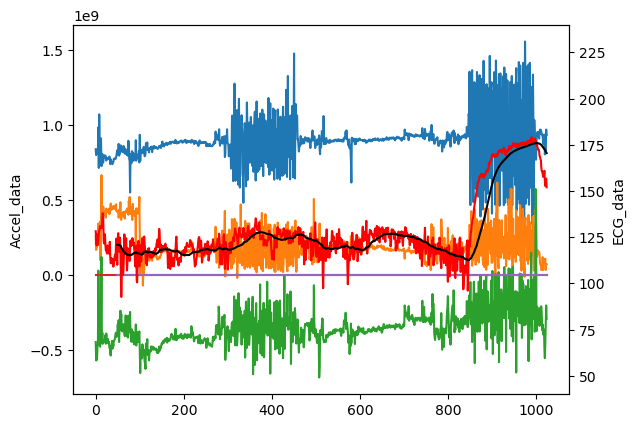

In [827]:
visualize_ECG_accel(sliced_accels[4], heart_rates[4], rollings[4])

In [779]:
def visualize_ECG_accel(accel_data, heart_rate_data, rolling_data, start_slice_factor=None, end_slice_factor=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(accel_data[start_slice_factor:end_slice_factor])
    ax1.set_ylabel('Accel_data')

    ax2.plot(heart_rate_data[start_slice_factor:end_slice_factor], scaley=False, color='red')
    ax2.plot(rolling_data[start_slice_factor:end_slice_factor], scaley=False, color='black')
    ax2.set_ylim([40,240])
    ax2.set_ylabel('ECG_data')

In [784]:
train_accels=[sliced_accels[0], sliced_accels[1], sliced_accels[2], sliced_accels[3], sliced_accels[4], sliced_accels[5]]
train_ECGs=[heart_rates[0], heart_rates[1], heart_rates[2], heart_rates[3], heart_rates[4], heart_rates[5]]
train_rolls=[rollings[0], rollings[1], rollings[2], rollings[3], rollings[4], rollings[5]]

In [787]:
for i,x,z in zip(train_accels, train_ECGs, train_rolls):
    i['heart_rate']=x
    i['rolling']=z

In [788]:
train_accels[0]

Accelerometer_X  Accelerometer_Y  Accelerometer_Z  heart_rate    rolling
0        9.100000e+08     -107500000.0    -3.930000e+08   94.118289        NaN
1        8.610000e+08      -94000000.0    -4.220000e+08   99.330511        NaN
2        8.865000e+08      -62500000.0    -4.025000e+08   89.121586        NaN
3        9.275000e+08      -51000000.0    -4.200000e+08   79.968218        NaN
4        8.005000e+08     -219000000.0    -5.215000e+08   83.017485        NaN
...               ...              ...              ...         ...        ...
1424    -8.000000e+06        5500000.0    -9.965000e+08  100.814877  92.543763
1425    -1.200000e+07       13500000.0    -1.016000e+09   93.014554  92.271992
1426    -8.000000e+06        9500000.0    -1.010000e+09   97.560976  92.012997
1427    -9.094947e-09       11500000.0    -1.006000e+09   67.032963  91.216883
1429     4.785000e+08      589500000.0    -6.310000e+08   71.326688  90.750657

[1326 rows x 5 columns]

In [791]:
train_adjustments[0][0]

40

In [793]:
sliced_dfs=[]
for i,x in zip(train_accels, train_adjustments):
    sliced_df=i[x[0]:x[1]]
    sliced_dfs.append(sliced_df)

Accelerometer_X  Accelerometer_Y  Accelerometer_Z  heart_rate  \
140      8.375000e+08      164000000.0     -467000000.0   77.510603   
141      8.320000e+08      169500000.0     -473000000.0   77.846276   
145      8.375000e+08      164000000.0     -469000000.0   72.100164   
146      8.395000e+08      164000000.0     -475000000.0   83.482710   
150      8.320000e+08      166000000.0     -477000000.0   75.087727   
...               ...              ...              ...         ...   
1022     4.960000e+08      162000000.0     -102000000.0  141.173670   
1023     1.128500e+09      310500000.0     -307000000.0  139.739697   
1024     7.300000e+08       60500000.0     -400500000.0  140.147143   
1025     9.020000e+08      -20000000.0      -53000000.0  140.715779   
1026     9.430000e+08      324000000.0     -414500000.0  141.373978   

         rolling  
140    70.539173  
141    70.850879  
145    70.936439  
146    71.033235  
150    70.979078  
...          ...  
1022  136.811911  
1023  136.877137  
1024  137.014426  
1025  137.275539  
1026  137.480937  

[858 rows x 5 columns]

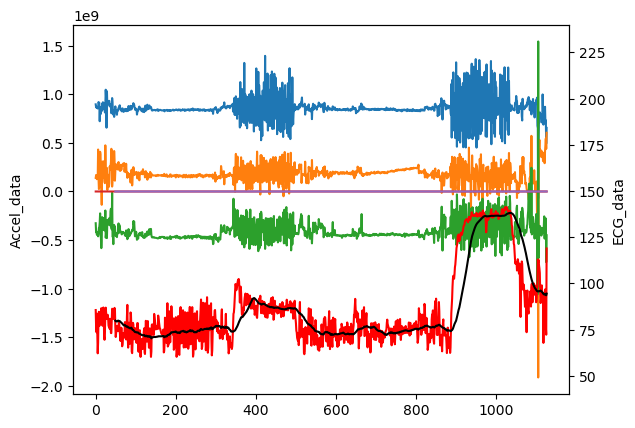

In [831]:
visualize_ECG_accel(sliced_accels[5], heart_rates[5], rollings[5])

In [835]:
nk2.cluster_findnumber(sliced_dfs[0].dropna(), n_max=4)

n_Clusters  Score_Silhouette  Score_Calinski  Score_Bouldin  \
0         1.0               NaN             NaN            NaN   
1         2.0          0.614070      509.774902       0.831546   
2         3.0          0.559243      677.061846       0.751697   

   Score_VarianceExplained  Score_GEV  Score_CrossValidation    Dispersion  \
0                 0.000000   0.987541          -3.920123e+35  4.616279e+19   
1                 0.299028   0.987602          -9.532154e+35  3.235884e+19   
2                 0.531420   0.988561          -3.928297e+36  2.163096e+19   

   Score_GAP  Score_GAPmod  Score_GAP_diff  Score_GAPmod_diff  
0   1.807702  2.352884e+20       -0.627837       2.526891e+20  
1   2.471814  3.511256e+20       -0.262440       3.711204e+20  
2   2.853033  3.558526e+20             NaN                NaN

In [836]:
clustering_kmeans, clusters_kmeans, info=nk2.cluster(sliced_dfs[0].dropna(), n_clusters=2)

In [819]:
clusters_kmeans[2]

array([ 8.95689447e+08,  2.19438191e+08, -2.93526633e+08,  9.55895270e+01,
        9.62919397e+01])

In [838]:
clustering_kmeans[clustering_kmeans['Cluster']==0]

Distance_0    Distance_1  Cluster
0     1.418281e+08  4.025362e+08        0
1     1.557682e+08  4.013620e+08        0
2     1.781832e+08  4.301296e+08        0
3     1.367851e+08  4.009512e+08        0
4     1.530763e+08  3.841830e+08        0
...            ...           ...      ...
1192  1.012100e+08  3.868440e+08        0
1193  7.695441e+07  3.827546e+08        0
1194  1.070350e+08  3.989338e+08        0
1195  1.348185e+08  4.142275e+08        0
1196  1.163441e+08  4.045361e+08        0

[1111 rows x 3 columns]

In [840]:
big_test=pd.concat(sliced_dfs, axis=0)

In [843]:
big_test=big_test.dropna()

In [844]:
nk2.cluster_findnumber(big_test, n_max=4)

n_Clusters  Score_Silhouette  Score_Calinski  Score_Bouldin  \
0         1.0               NaN             NaN            NaN   
1         2.0          0.501905     1681.222446       1.069492   
2         3.0          0.327187     1948.973098       1.250367   

   Score_VarianceExplained  Score_GEV  Score_CrossValidation    Dispersion  \
0             3.651882e-16   0.978849          -3.967711e+35  2.691872e+20   
1             2.266036e-01   0.979095          -9.549855e+35  2.081885e+20   
2             4.045634e-01   0.984272          -3.891621e+36  1.602840e+20   

   Score_GAP  Score_GAPmod  Score_GAP_diff  Score_GAPmod_diff  
0   1.888677  1.510382e+21       -0.529074       1.615959e+21  
1   2.430837  2.158763e+21       -0.160057       2.272639e+21  
2   2.674488  2.171881e+21             NaN                NaN

In [849]:
sliced_accels[0].rolling(100).mean().iloc[:,:3]

Accelerometer_X  Accelerometer_Y  Accelerometer_Z
0                 NaN              NaN              NaN
1                 NaN              NaN              NaN
2                 NaN              NaN              NaN
3                 NaN              NaN              NaN
4                 NaN              NaN              NaN
...               ...              ...              ...
1424      582910000.0       50410000.0     -373315000.0
1425      573495000.0       51760000.0     -381170000.0
1426      564220000.0       52775000.0     -388300000.0
1427      555455000.0       50355000.0     -395485000.0
1429      551335000.0       54945000.0     -398395000.0

[1326 rows x 3 columns]

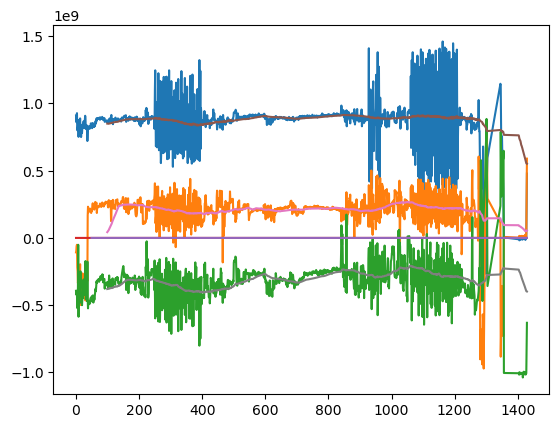

In [850]:
plt.plot(sliced_accels[0])
plt.plot(sliced_accels[0].rolling(100).mean().iloc[:,:3])

# Moving all of this over to a new file to speed up processing....